In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import statsmodels.api as sm
import math

In [35]:
folder_path =  '/users/mmotuz/GBO_REU/GOALS/'

df1 = pd.read_csv(folder_path + 'goals_v6.csv', skiprows = None)

df2 = pd.read_csv(folder_path + 'TABmeas_v2.csv', skiprows = None)

df3 = pd.read_csv(folder_path + 'COData.csv', skiprows = None)

df4 = pd.read_csv(folder_path + 'Motuz.csv', skiprows = None)



In [36]:
df2 = df2.merge(df4[['SOURCE', 'Mstar(MS)']], how='left', left_on='name', right_on='SOURCE')
df2['Mstar(MS)'] = df2['Mstar(MS)'].fillna(np.nan)
df2 = df2.drop(columns=['SOURCE'])

In [37]:
df2

,name,int_time,S_HISign,S_HI,S_HIErr,HI_Vel,HI_VelErr,W50,W50Err,W20,...,CFD,CFDErr,CPSSign,CPS,CRMS,MassSign,Log(M_HI),LogM_HIErr,ProfileCode,Mstar(MS)
0,F00073+2538,65.2,NaN,9.04,0.91,4567.0,6.0,381.4,11.5,453.1,...,0.195,0.065,NaN,29.18,1.95,NaN,9.94,0.04,EM_NG,1.590000e+11
1,F00085-1223,84.1,NaN,4.48,0.46,5881.0,20.0,292.6,54.2,432.4,...,0.195,0.065,NaN,21.01,2.08,NaN,9.86,0.04,EM_NG,1.100000e+11
2,F00163-1039,117.5,NaN,5.95,0.60,8143.0,5.0,257.6,8.8,309.5,...,0.951,0.115,NaN,32.08,1.96,NaN,10.26,0.04,EM_NG,1.800000e+11
3,F00344-3349,89.0,NaN,0.13,0.06,6238.0,25.0,90.6,12.6,147.9,...,0.195,0.065,NaN,8.69,1.63,NaN,8.37,0.18,EM_G,4.630000e+10
4,F00402-2349,95.2,NaN,2.01,0.21,6762.0,19.0,255.3,20.5,329.6,...,0.195,0.065,NaN,11.29,1.68,NaN,9.61,0.05,EM_NG,1.940000e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,F23394-0353,100.0,NaN,10.95,1.10,6932.0,12.0,248.7,23.2,400.0,...,0.195,0.065,NaN,52.12,1.90,NaN,10.39,0.04,EM_NG,2.080000e+11
157,23436+5257,149.0,NaN,1.15,0.12,10248.0,18.0,156.4,29.8,241.6,...,0.195,0.065,NaN,9.70,1.07,NaN,9.75,0.05,EM_NG,NaN
158,F23444+2911,73.6,NaN,26.90,2.69,5144.0,5.0,372.5,5.0,431.1,...,0.195,0.065,NaN,89.20,2.93,NaN,10.52,0.04,EM_NG,2.840000e+11
159,F23488+1949,61.2,NaN,18.82,1.89,4299.0,10.0,466.0,19.7,617.4,...,0.195,0.065,NaN,49.27,2.23,NaN,10.21,0.04,EM_NG,4.000000e+11


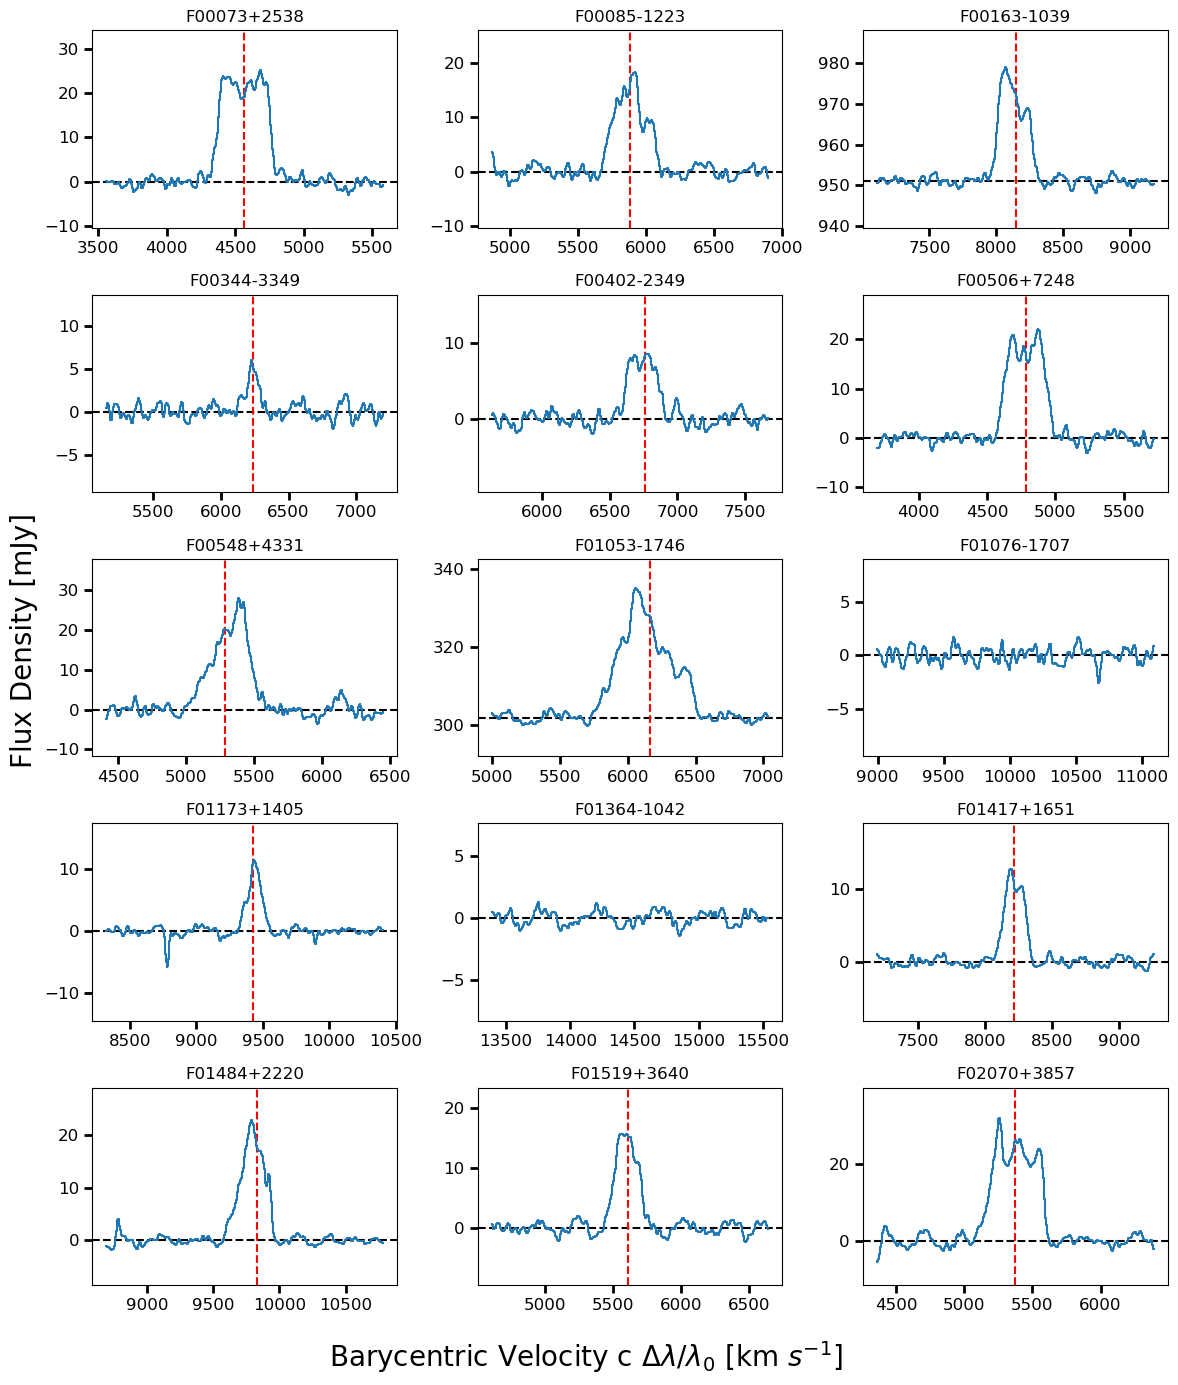

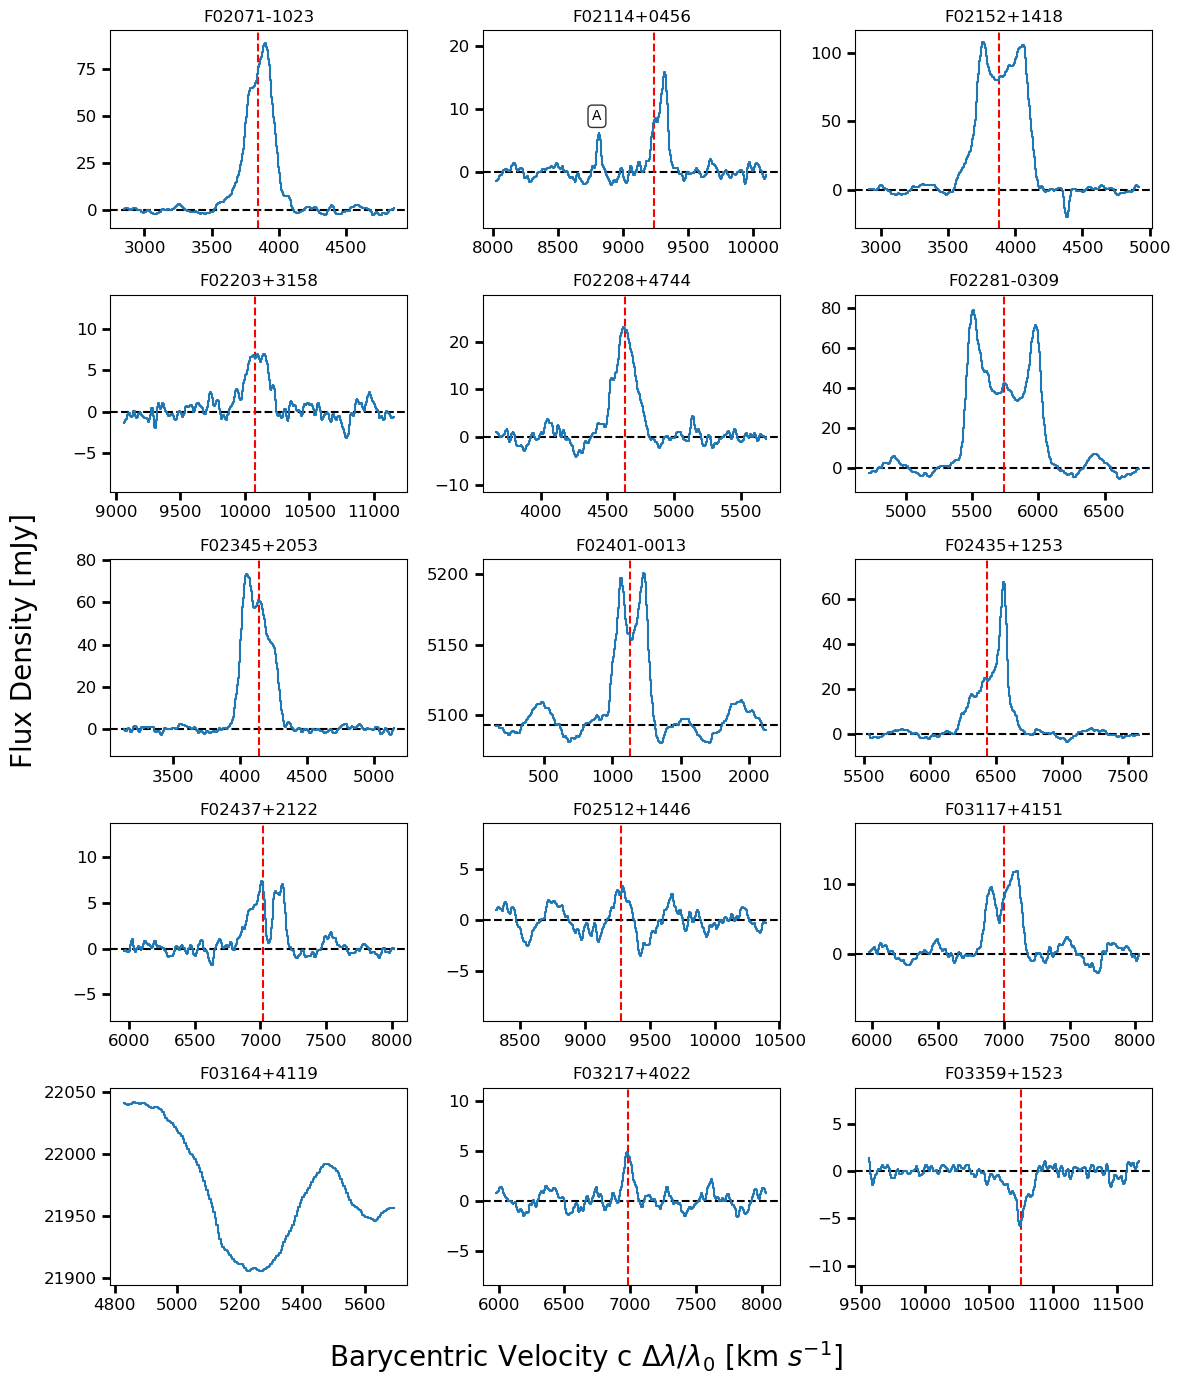

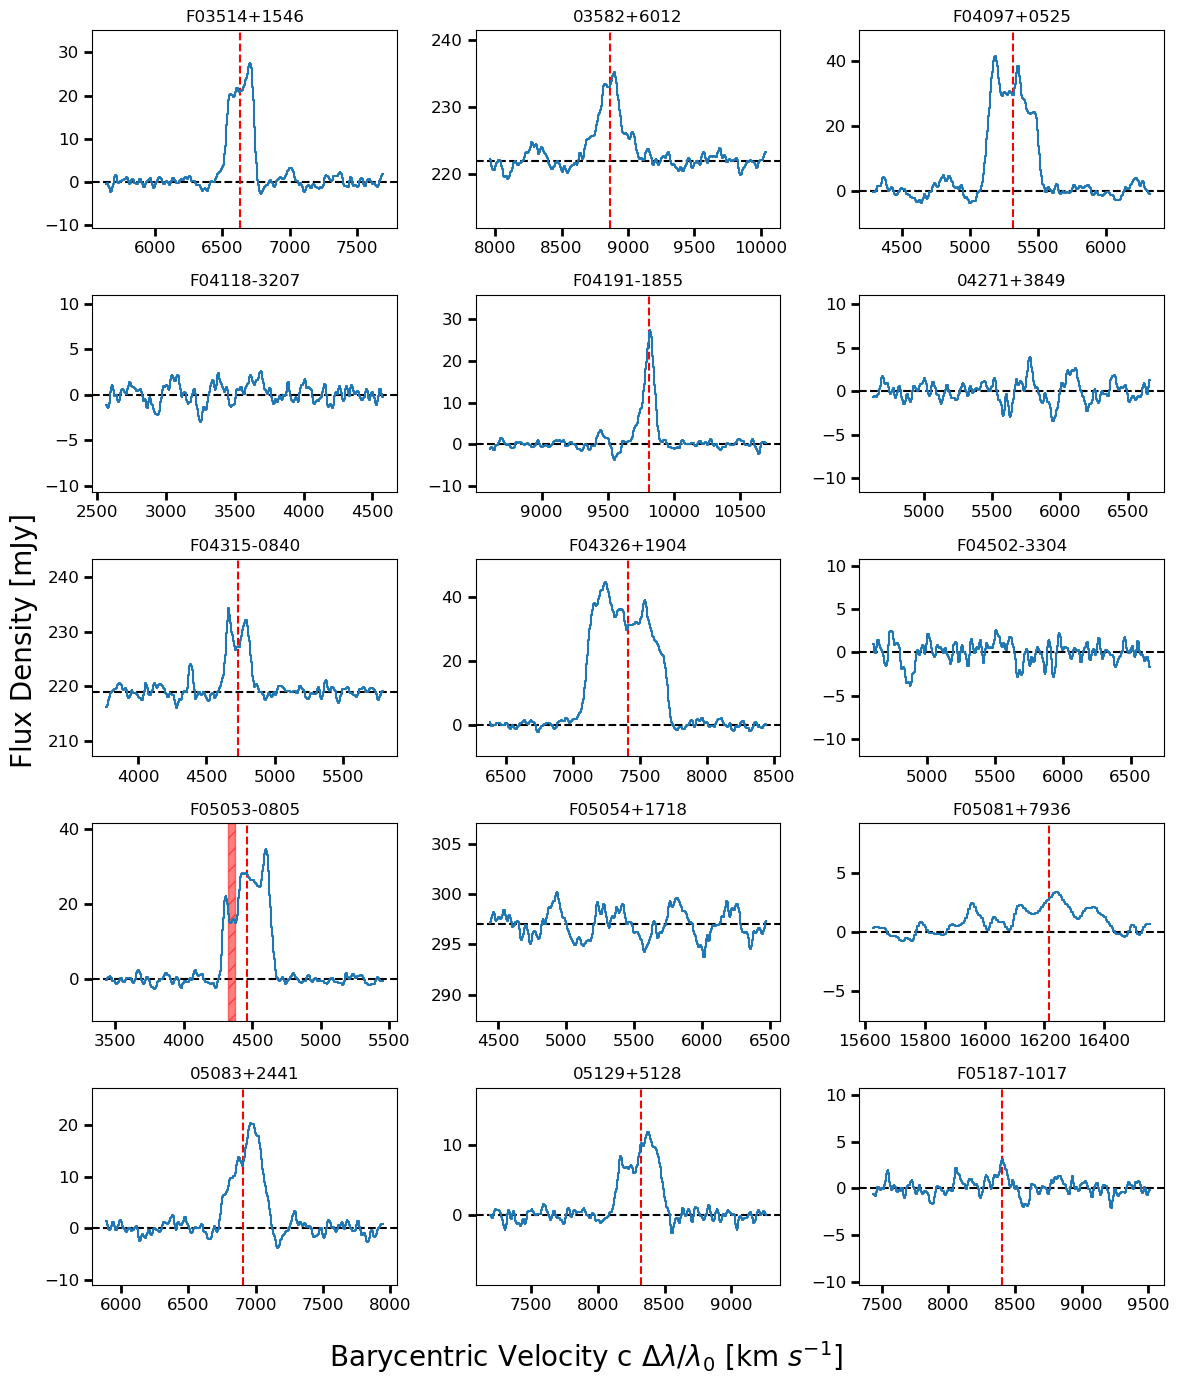

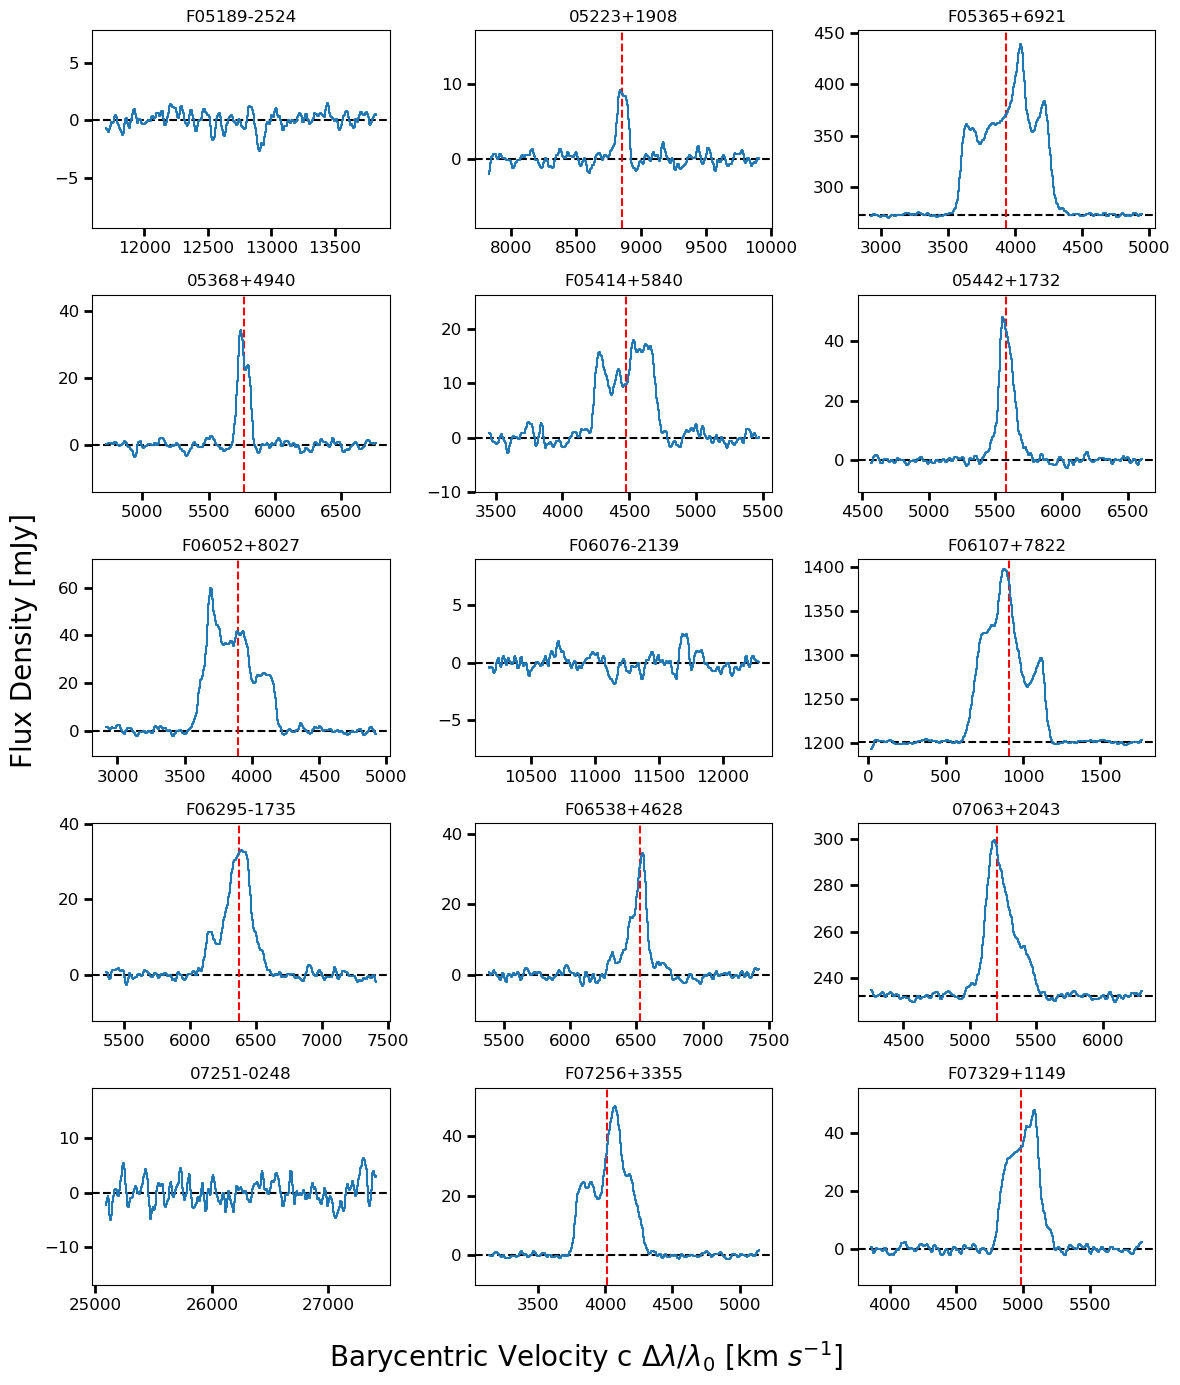

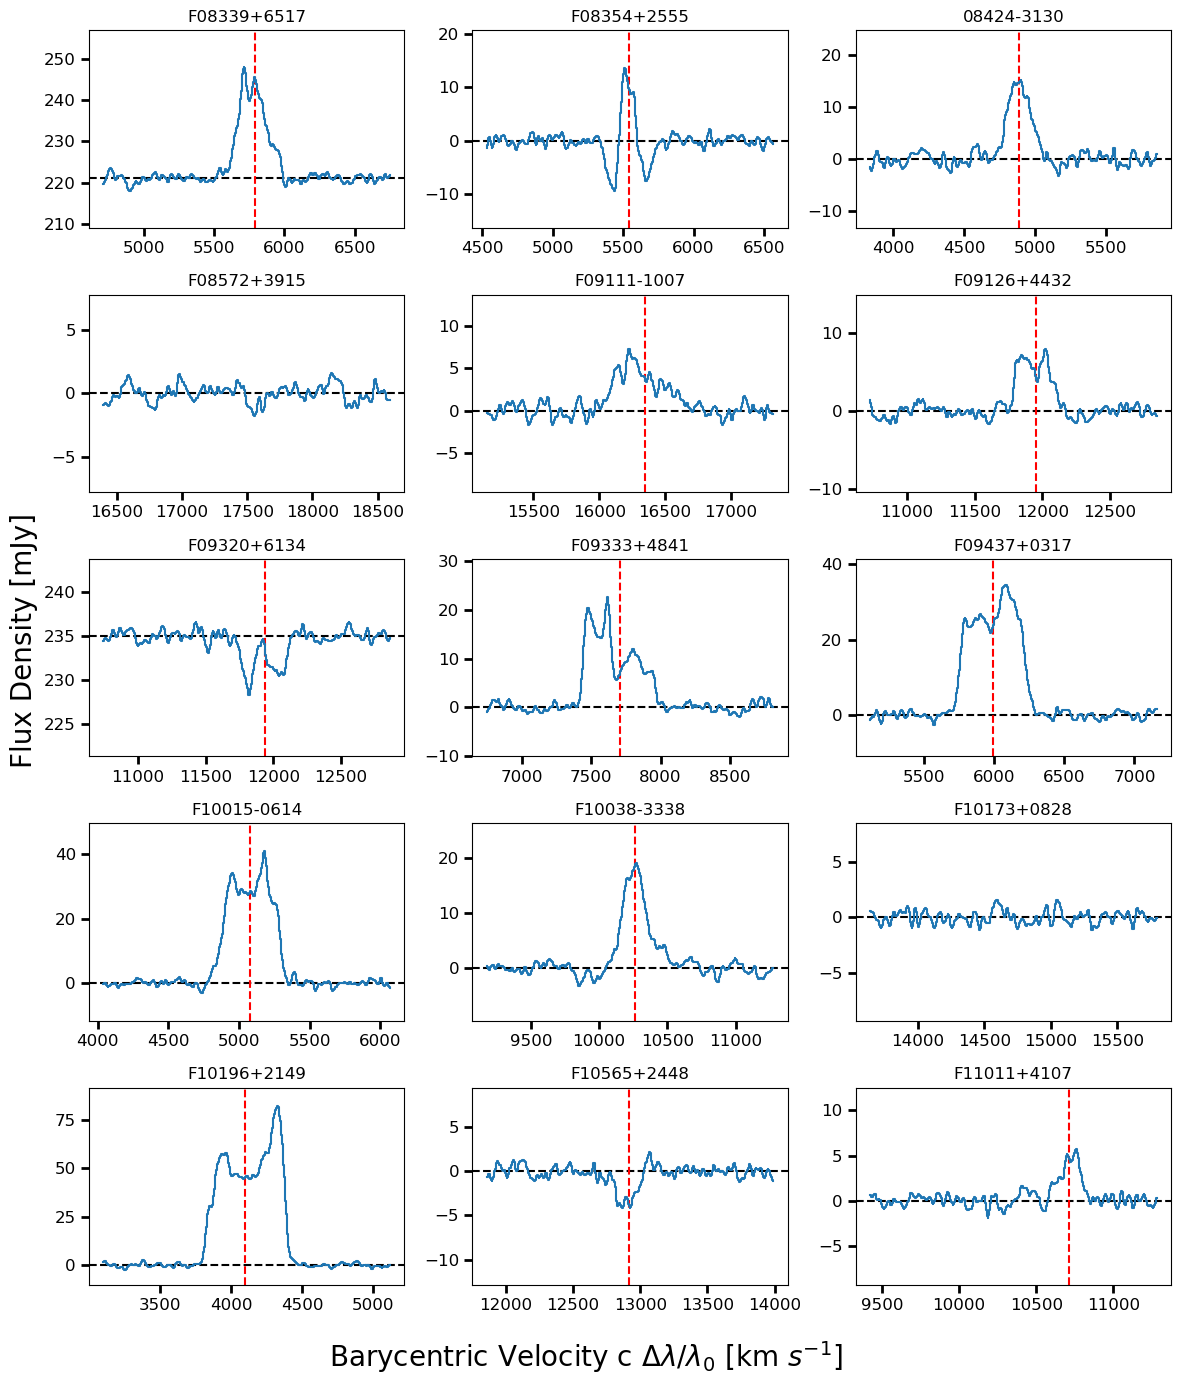

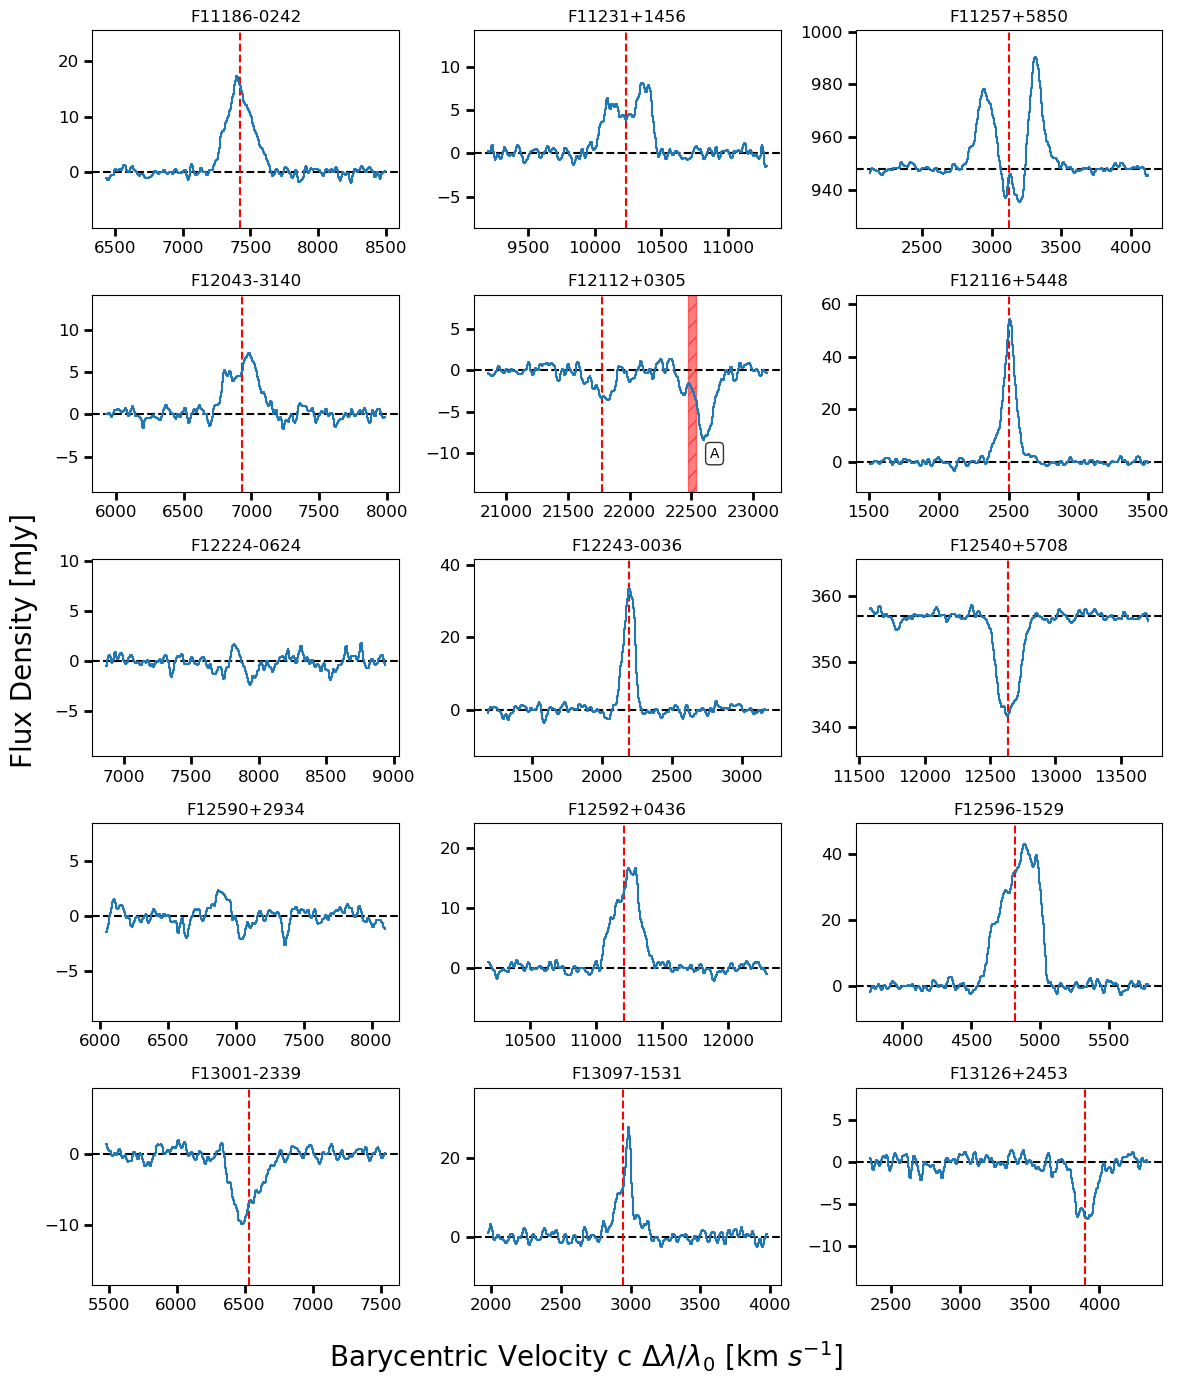

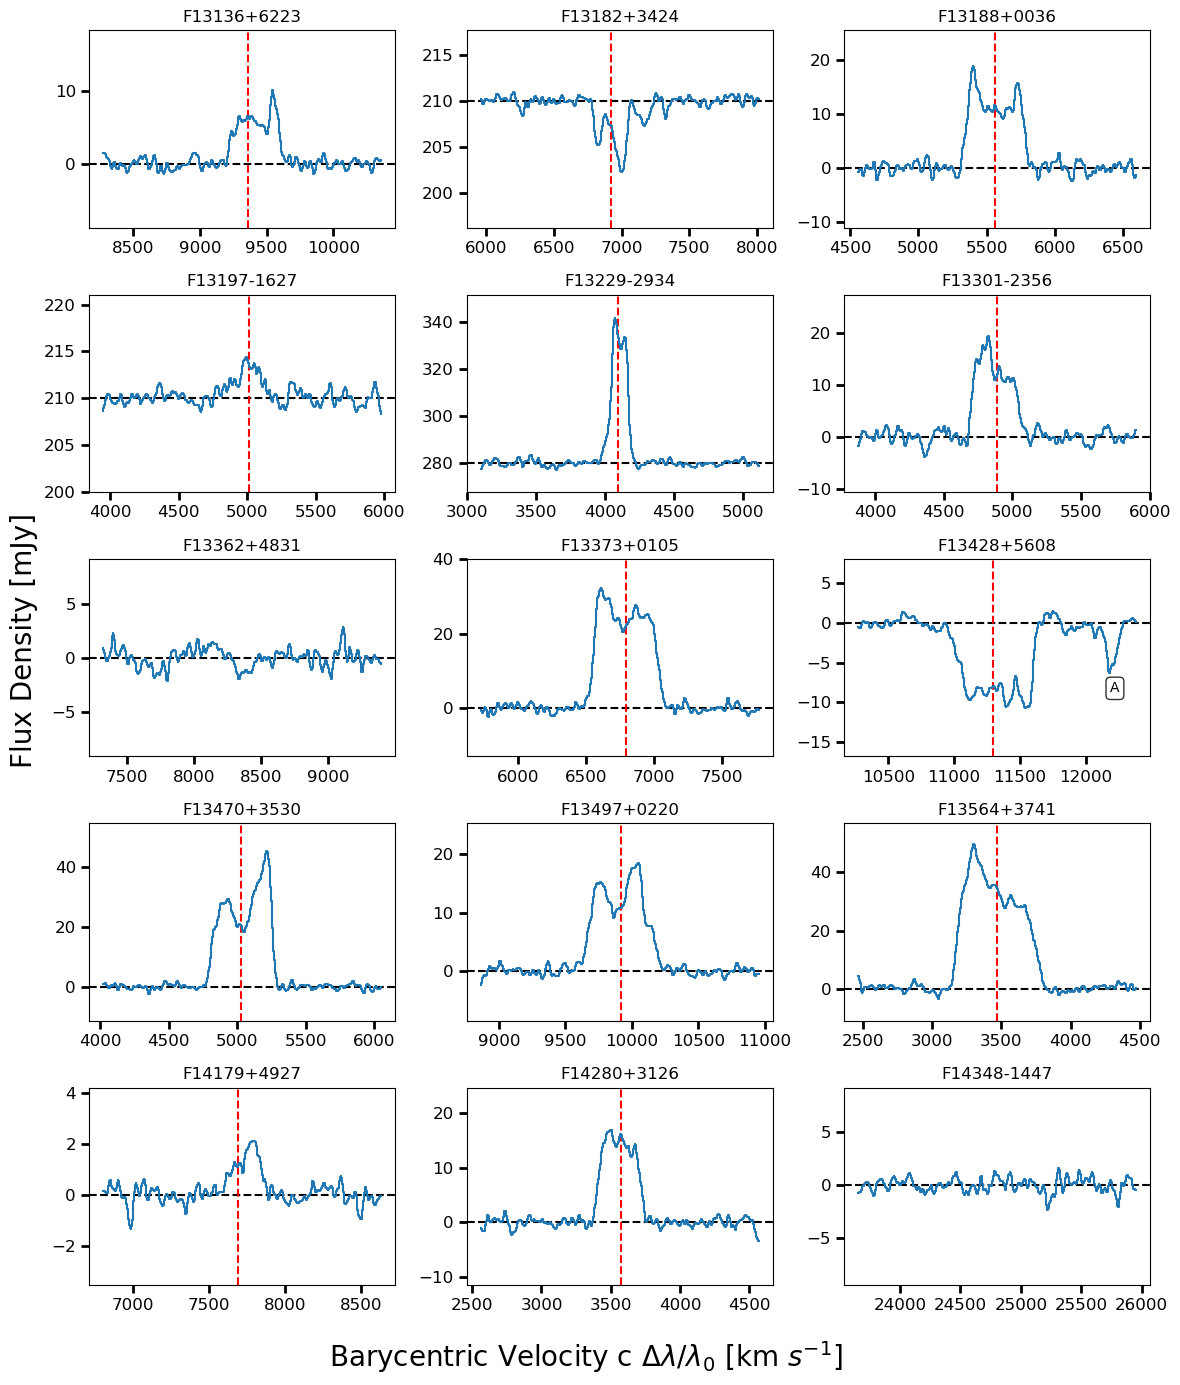

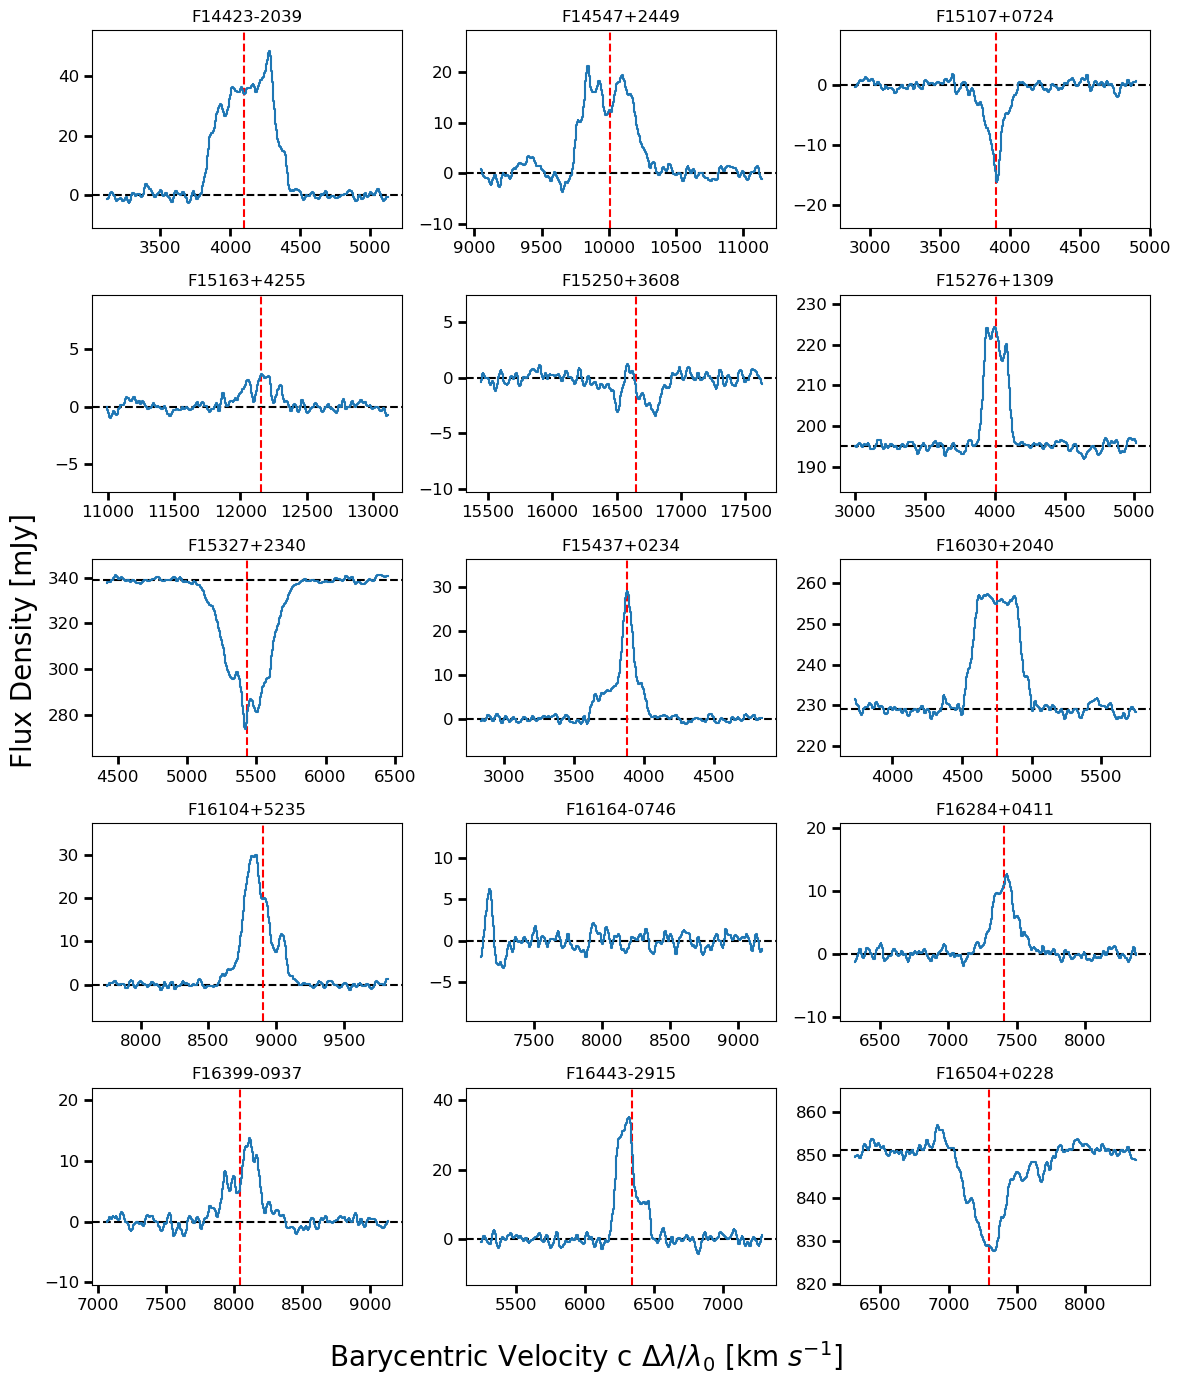

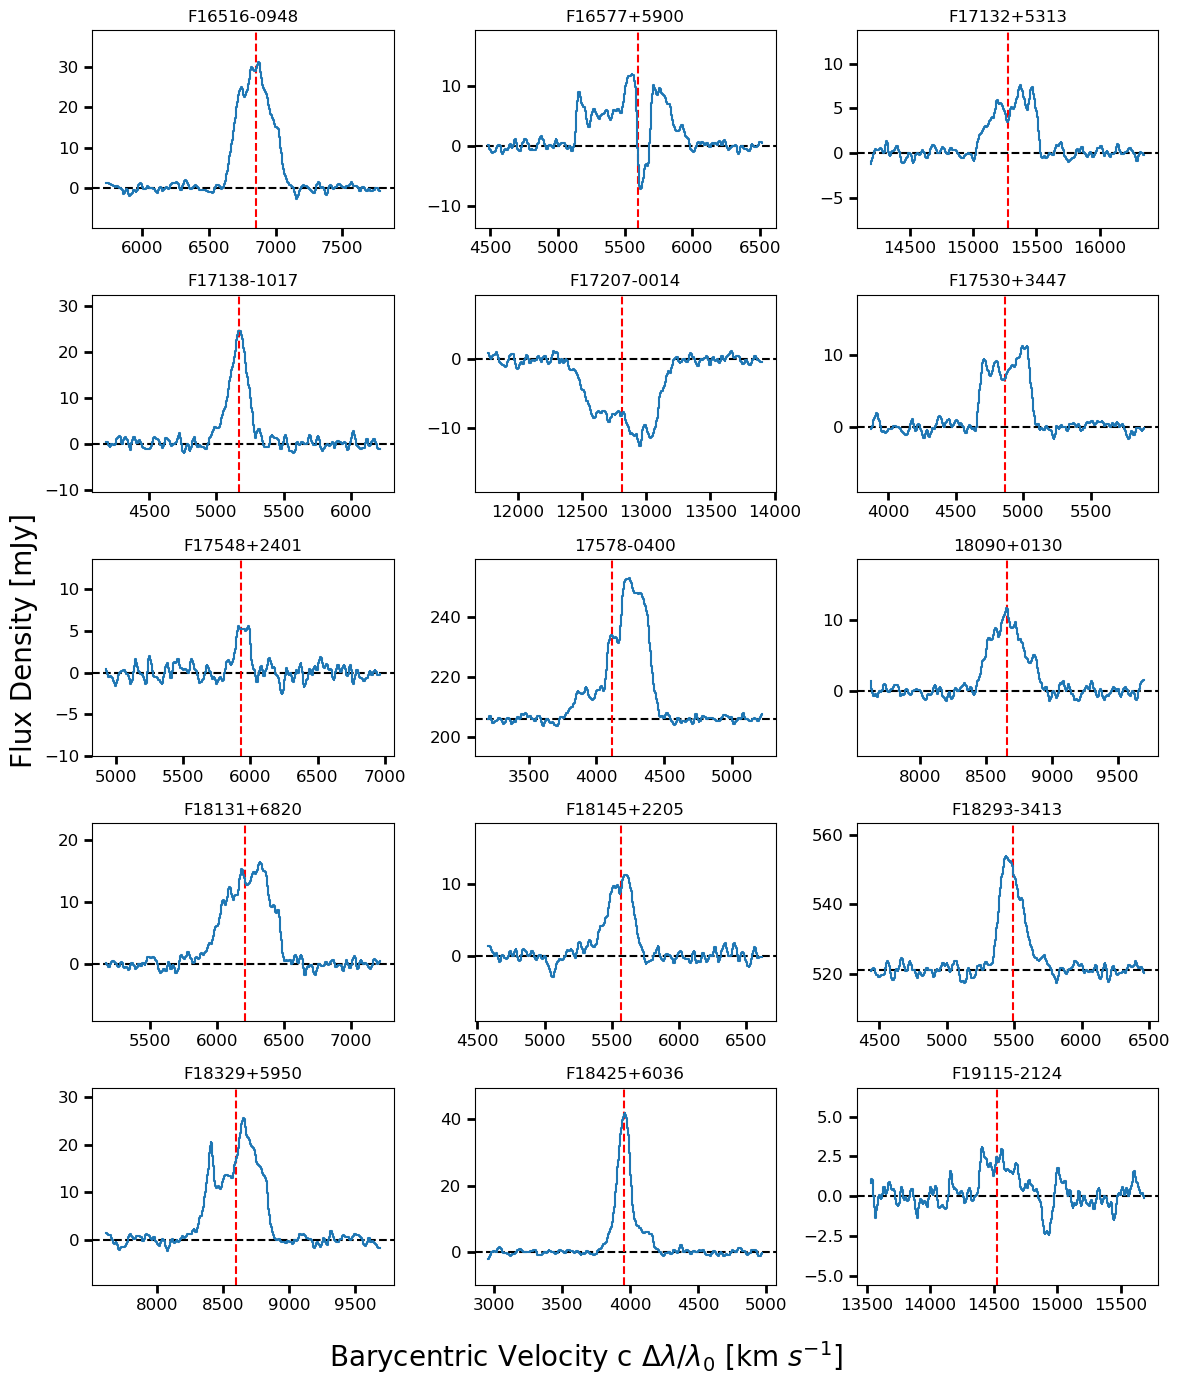

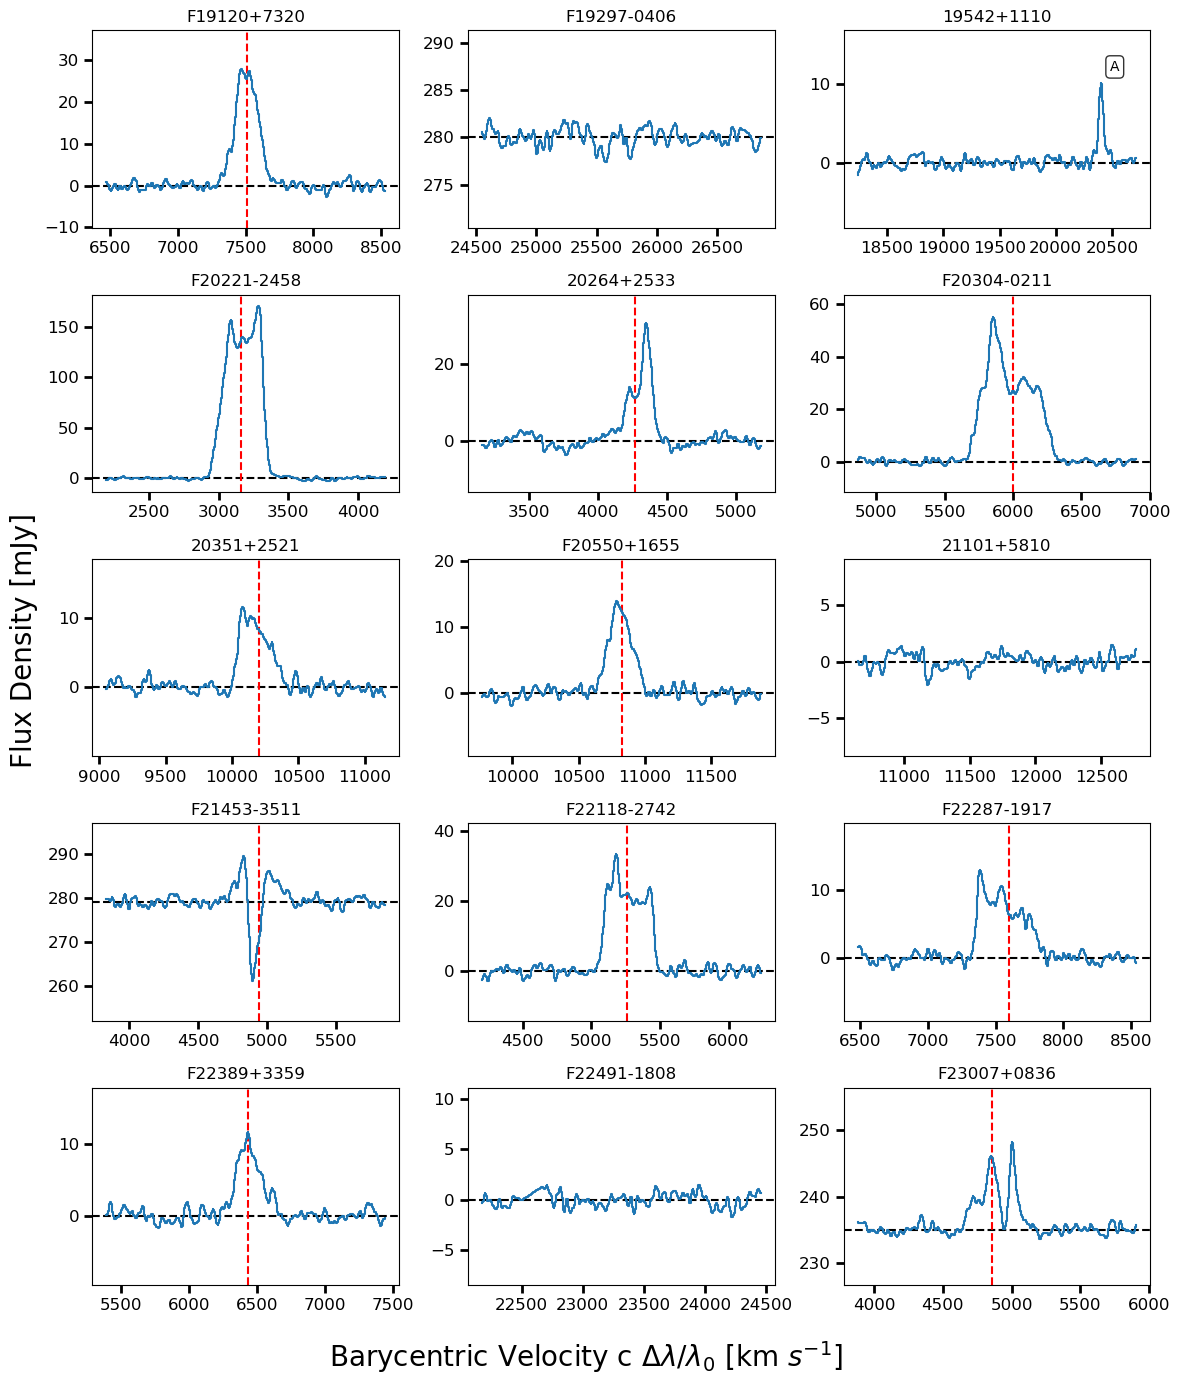

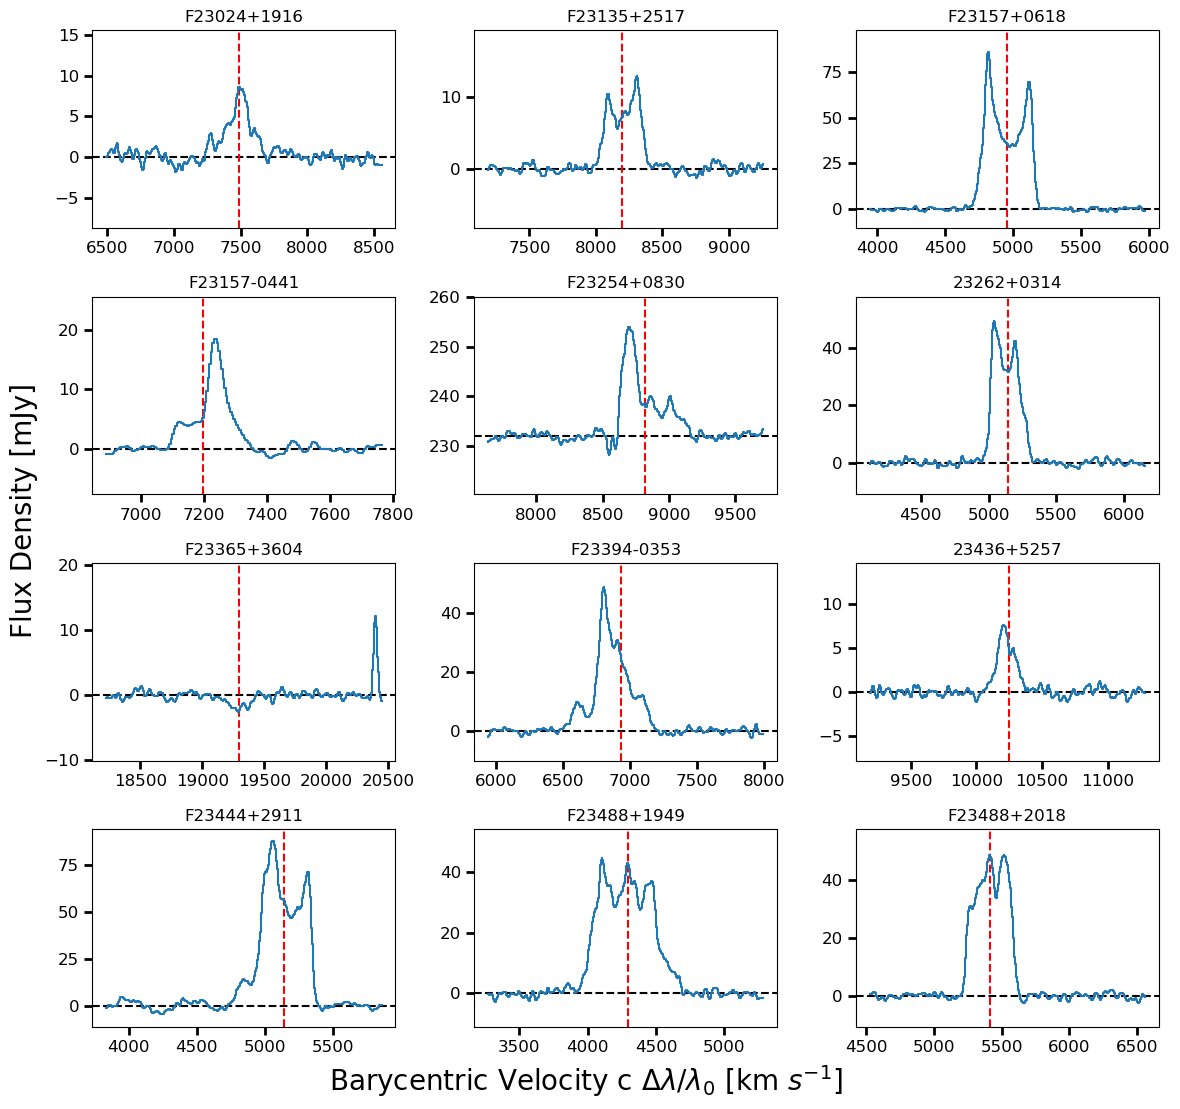

In [38]:
# --- Collect valid .txt files ---
txt_files = sorted([f for f in os.listdir(folder_path + 'DATAv3/TXT') if f.endswith('.txt')])
valid_files = []
valid_data = []

# --- Load and filter valid 2-column txts ---
for filename in txt_files:
    path = os.path.join(folder_path + 'DATAv3/TXT', filename)
    try:
        df = pd.read_csv(path, sep='\s+', skiprows=3, header=None)
        if df.shape[1] == 2:
            valid_files.append(filename)
            valid_data.append(df)
    except Exception as e:
        print(f"Skipping {filename}: {e}")

# --- Apply CFD correction to valid_data if CFDSign is NaN ---
for idx, file in enumerate(valid_files):
    base_name = file.replace('_v2.txt', '').lstrip('F')
    df2_names = df2.name.astype(str).str.lstrip('F')
    match_idx = (df2_names == base_name)
    if match_idx.any():
        match = df2.loc[match_idx]
        cfd_sign = match['CFDSign'].values[0]
        cfd = match['CFD'].values[0]
        matched_name = match['name'].values[0]
        if base_name == '05053-0805':
            valid_data[idx][1] = valid_data[idx][1] - np.median(valid_data[idx][1])
        if pd.isna(cfd_sign):
            valid_data[idx][1] = valid_data[idx][1] + cfd
    else:
        matched_name = file.replace('_v2.txt', '')

# --- Plot in batches of 15 (3 columns × 5 rows) ---
batch_size = 15
total = len(valid_files)
num_batches = math.ceil(total / batch_size)

for b in range(num_batches):
    start = b * batch_size
    end = min(start + batch_size, total)
    batch_files = valid_files[start:end]
    batch_data = valid_data[start:end]
    n = len(batch_files)
    cols = 3
    rows = 5
    if b == num_batches - 1:
        rows = 4

    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten()

    for i in range(n):
        base_name = batch_files[i].replace('_v2.txt', '').lstrip('F')
        df2_names = df2.name.astype(str).str.lstrip('F')
        match_idx = (df2_names == base_name)
        if match_idx.any():
            matched_name = df2.loc[match_idx, 'name'].values[0]
        else:
            matched_name = batch_files[i].replace('_v2.txt', '')

        # Set slicing indices
        if any(x in batch_files[i] for x in ['F23157-0441', 'F03164+4119', 'F05081+7936']):
            begin = 200
            stop = -200
        elif any(x in batch_files[i] for x in ['F06107+7822_v2.txt', 'F11011+4107', 'F14179+4927']):
            begin = 100
            stop = -100
        elif any(x in batch_files[i] for x in ['F19542+1110']):
            begin = 50
            stop = -50
        else:
            begin = 75
            stop = -75

        data_len = len(batch_data[i][0])
        start_idx = begin if begin >= 0 else max(data_len + begin, 0)
        stop_idx = stop if stop >= 0 else max(data_len + stop, 0)
        if stop_idx <= start_idx:
            stop_idx = data_len

        ax = axes[i]
        ax.plot(
            batch_data[i][0][start_idx:stop_idx],
            gaussian_filter1d(batch_data[i][1][start_idx:stop_idx], 2) * 1000,
            drawstyle='steps-mid', zorder=2
        )

        buffer = 1 if any(x in batch_files[i] for x in ['F14179+4927', 'F19115-2124']) else 5
        ax.set_ylim(
            np.min(batch_data[i][1][start_idx:stop_idx] * 1000) - buffer,
            np.max(batch_data[i][1][start_idx:stop_idx] * 1000) + buffer
        )

        # Draw horizontal line
        if np.median(gaussian_filter1d(batch_data[i][1][start_idx:stop_idx], 2) * 1000) < 20:
            ax.axhline(y=0, color='black', linestyle='--', zorder=1)
        else:
            cfd_value = df2[df2['name'] == matched_name]['CFD'].values
            if len(cfd_value) > 0:
                ax.axhline(y=cfd_value[0] * 1000, color='black', linestyle='--', zorder=1)
            else:
                ax.axhline(y=0, color='black', linestyle='--', zorder=1)

        # Special highlights and annotations
        if batch_files[i] == 'F05053-0805_v2.txt':
            ax.axvspan(4325, 4375, color='r', hatch='//', alpha=0.5, zorder=1)
        if batch_files[i] == 'F12112+0305_v2.txt':
            ax.axvspan(22470, 22540, color='r', hatch='//', alpha=0.5, zorder=1)
            ax.text(0.8, 0.23, 'A', transform=ax.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        if batch_files[i] == 'F13428+5608_v2.txt':
            ax.text(0.9, 0.38, 'A', transform=ax.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        if batch_files[i] == 'F19542+1110_v2.txt':
            ax.text(0.9, 0.85, 'A', transform=ax.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        if batch_files[i] == 'F02114+0456_v2.txt':
            ax.text(0.4, 0.6, 'A', transform=ax.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        ax.set_title(matched_name)
        ax.tick_params(axis='both', which='both', length=6, width=2, labelsize=12)

        # Draw vertical line at HI velocity if available and line[Jykm/s] != 0
        line_val = df1.loc[df1['name'] == matched_name, 'line[Jykm/s]']
        hi_vel_val = df2.loc[df2['name'] == matched_name, 'HI_Vel']
        if not line_val.empty and line_val.values[0] != 0 and not hi_vel_val.empty:
            ax.axvline(x=hi_vel_val.values[0], color='red', linestyle='--', zorder=1, label='HI Velocity')

    # Hide unused subplots in the final (partial) batch
    for j in range(n, len(axes)):
        fig.delaxes(axes[j])

    # Shared labels and title
    fig.supxlabel(r'Barycentric Velocity c $\Delta\lambda / \lambda_0$ [km $s^{-1}$]', fontsize=20)
    fig.supylabel('Flux Density [mJy]', fontsize=20)

    # Layout adjustments
    plt.tight_layout(rect=[0, 0.05, 1, 0.93])
    fig.subplots_adjust(bottom=0.07)
    plt.savefig('spectra_batch_{}.png'.format(b + 1))
    plt.show()
    plt.close(fig)

In [39]:
def plotWithFit(X, y, xlabel, ylabel):
    X_ = sm.add_constant(X)
    # Fit LAD regression (Quantile Regression at q=0.5)
    mod = sm.QuantReg(y, X_)
    res = mod.fit(q=0.5)
    # Predict over a smooth range for plotting
    X_pred = np.linspace(X.min(), X.max(), 100)
    X_pred_ = sm.add_constant(X_pred)
    y_pred = res.predict(X_pred_)
    slope = res.params[1]
    intercept = res.params[0]
    plt.figure()
    plt.loglog(np.power(10,X), np.power(10, y), 'o', markersize=5, alpha=0.5)
    plt.plot(np.power(10, X_pred), np.power(10, y_pred), color='red', linewidth=2,
         label=f'LAD fit: slope = {res.params[1]:.4f}, intercept = {res.params[0]:.3f}')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    #plt.legend()
    plt.savefig('figFit.png')
    plt.show()

    return slope, intercept

def plotWithFitErr(X, y, yerr, bin, xlabel, ylabel):


    idx = np.argsort(X)
    X = X.iloc[idx]
    y = y.iloc[idx]
    yerr = yerr.iloc[idx]
    yerr = yerr/2.3


    # Fit LAD (Quantile Regression at q=0.5)
    X_ = sm.add_constant(X)
    mod = sm.QuantReg(y, X_)
    res = mod.fit(q=0.5)

    # Smooth prediction line
    X_pred = np.linspace(X.min(), X.max(), 100)
    X_pred_ = sm.add_constant(X_pred)
    y_pred = res.predict(X_pred_)
    slope, intercept = res.params[1], res.params[0]

    X_bin = []
    newy = []
    MAD = []
    x_min = X.min()
    x_max = X.max()
    bins = np.arange(x_min, x_max + bin, bin)
    for i in range(len(bins) - 1):
        mask = (X >= bins[i]) & (X < bins[i+1])
        if np.any(mask):
            X_bin.append(X[mask].mean())
            newy.append(np.median(y[mask]))
            MAD.append(np.median(np.abs(y[mask] - np.median(y[mask]))))
    X_bin = np.array(X_bin)
    Mad = np.array(MAD)

    sigmaMAD = Mad * 1.48  # Convert MAD to standard deviation

    upper = newy + sigmaMAD
    lower = newy - sigmaMAD

    steepslope = (lower[-1] - upper[0]) / (X_bin[-1] - X_bin[0])

    lessslope = (upper[-1] - lower[0]) / (X_bin[-1] - X_bin[0])

    print(steepslope)
    print(lessslope)
    # Plotting
    plt.figure()
    plt.errorbar(X, y, yerr=yerr, fmt='o',
                 markersize=5, alpha=0.5, label='M/L Error')
    plt.plot(X_pred, y_pred, color='red', linewidth=0.5,
             label=f'LAD fit: slope = ${slope:.4f}$, intercept = ${intercept:.3f}$')
    plt.fill_between(X_bin,
                     upper,
                     lower,
                     color='red', alpha=0.3, label='MAD Error')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend()
    plt.savefig('figFitErr.png')
    plt.show()

    return slope, intercept



def plotWithFitMAD(X, y, bin):
    X_ = sm.add_constant(X)

    mod = sm.QuantReg(y, X_)
    res = mod.fit(q=0.5)

    X_pred = np.linspace(X.min(), X.max(), 100)
    X_pred_ = sm.add_constant(X_pred)
    y_pred = res.predict(X_pred_)
    slope, intercept = res.params[1], res.params[0]
    print(slope, intercept)
    plt.plot(10**X_pred, 10**y_pred, color='red', linewidth=2, label='LAD fit')

    X_bin = []
    newy = []
    MAD = []
    x_min = X.min()
    x_max = X.max()
    bins = np.arange(x_min, x_max + bin, bin)
    for i in range(len(bins) - 1):
        mask = (X >= bins[i]) & (X < bins[i+1])
        if np.any(mask):
            X_bin.append(X[mask].mean())
            newy.append(np.median(y[mask]))
            MAD.append(np.median(np.abs(y[mask] - np.median(y[mask]))))
    X_bin = np.array(X_bin)
    newy = np.array(newy)
    Mad = np.array(MAD)

    sigmaMAD = Mad * 1.48  # Convert MAD to standard deviation
    upper = newy + sigmaMAD
    lower = newy - sigmaMAD

    steepslope = (lower[-1] - upper[0]) / (X_bin[-1] - X_bin[0])
    lessslope = (upper[-1] - lower[0]) / (X_bin[-1] - X_bin[0])

    print(steepslope)
    print(lessslope)

    plt.fill_between(10**X_bin,
                     10**upper,
                     10**lower,
                     color='red', alpha=0.3, label='MAD Error')
    return slope, intercept

def sanityCheck(X, y, n, observed, label):
    slopes = []
    X_log = np.log10(X)
    for _ in range(n):
        shuffled_y = np.random.permutation(y)
        y_perm = np.log10(shuffled_y / X)
        X_ = sm.add_constant(X_log)
        mod = sm.QuantReg(y_perm, X_)
        res = mod.fit(q=0.5)
        slopes.append(res.params[1])
    plt.figure()
    plt.hist(slopes, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(x=observed, color='red', linestyle='--', label=f'Observed Slope = {observed:.4f}')
    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(f'sanity_check.png')
    plt.show()

In [40]:
logLir = df1['log(Lir)']
Lir = np.power(10, logLir) # Convert log Lir to Lir
dist = df1['Dlum[Mpc]']  # Use 'Dlum[Mpc]' for distance in Mpc
SHI = df1['line[Jykm/s]']
velocity = df1['50centerVel']

c = 299792.458 #km/s
z = velocity / c  # Convert velocity to redshift

percent_error = 0.1
M_h1 = (2.36e5/(1+z)**2) * SHI * dist**2

deltaV20 = df1.w20
Mdyn = 40 * deltaV20**4


In [41]:
exclude_codes = ['0', '3', '4', '5']
mask = (~df1.fit.astype(str).str.contains('|'.join(exclude_codes), na=False)) & (df1.w20 >= 0.0)

/tmp/ipykernel_355771/3053669086.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = res.params[1]
/tmp/ipykernel_355771/3053669086.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = res.params[0]
/tmp/ipykernel_355771/3053669086.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'LAD fit: slope = {res.params[1]:.4f}, intercept = {res.params[0]:.3f}')


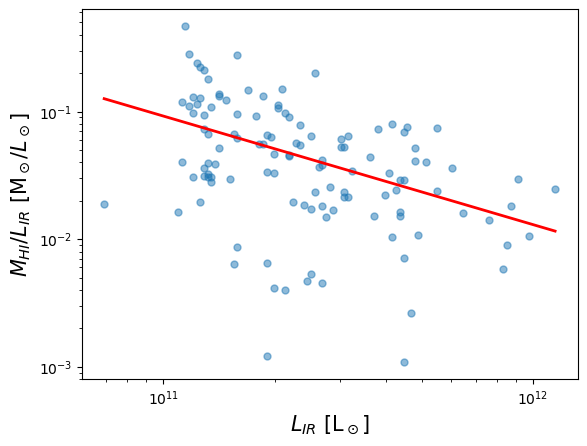

/home/scratch/gbosdd/conda/envs/student-rhel8/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/scratch/gbosdd/conda/envs/student-rhel8/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


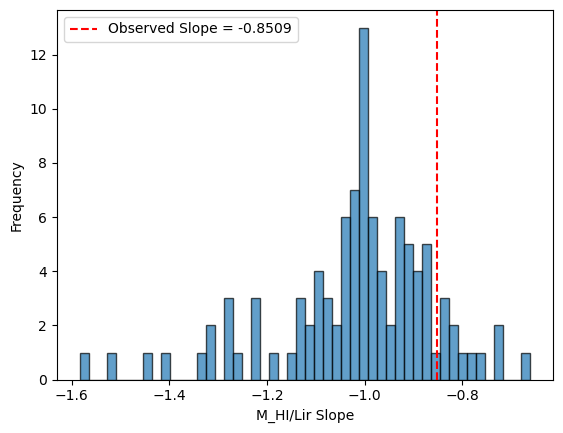

-0.8508618569993384


In [42]:
MhLVLSlope, MhLVLIntercept = plotWithFit(logLir[mask], np.log10(M_h1[mask]/Lir[mask]),
                                       r'$L_{IR}$ [L$_\odot$]', r'$M_{H I}/L_{IR}$ [M$_\odot/L_\odot$]')

sanityCheck(np.power(10, logLir)[mask].values, M_h1[mask].values, 100, MhLVLSlope, 'M_HI/Lir Slope')

print(MhLVLSlope)

/tmp/ipykernel_355771/3053669086.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = res.params[1]
/tmp/ipykernel_355771/3053669086.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = res.params[0]
/tmp/ipykernel_355771/3053669086.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'LAD fit: slope = {res.params[1]:.4f}, intercept = {res.params[0]:.3f}')


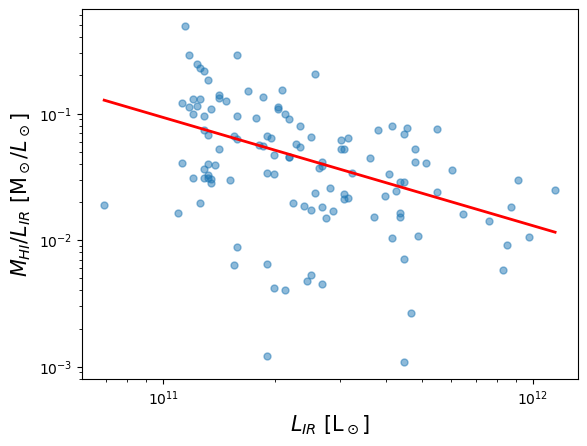

In [43]:
mhlSlopeErr, mhlInterceptErr = plotWithFit(logLir[mask], np.log10(M_h1[mask]/Lir[mask]) + (M_h1[mask]/Lir[mask]) * percent_error/2.3,
                                       r'$L_{IR}$ [L$_\odot$]', r'$M_{H I}/L_{IR}$ [M$_\odot/L_\odot$]')

/tmp/ipykernel_355771/3053669086.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = res.params[1], res.params[0]


-1.2300189385872375
0.4504331107089148


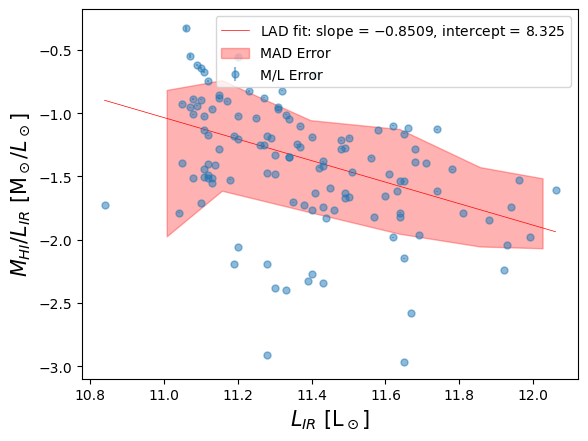

(-0.850861856987233, 8.324552803712699)

In [44]:
plotWithFitErr(logLir[mask], np.log10(M_h1[mask]/Lir[mask]), 
               (M_h1[mask]/Lir[mask] * percent_error), .225,
               r'$L_{IR}$ [L$_\odot$]', r'$M_{H I}/L_{IR}$ [M$_\odot/L_\odot$]')

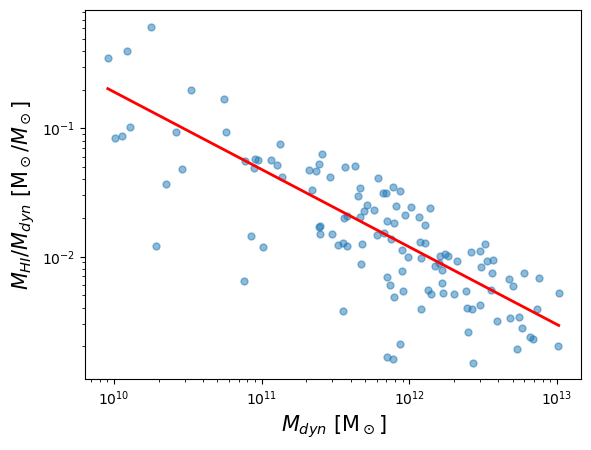

/home/scratch/gbosdd/conda/envs/student-rhel8/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


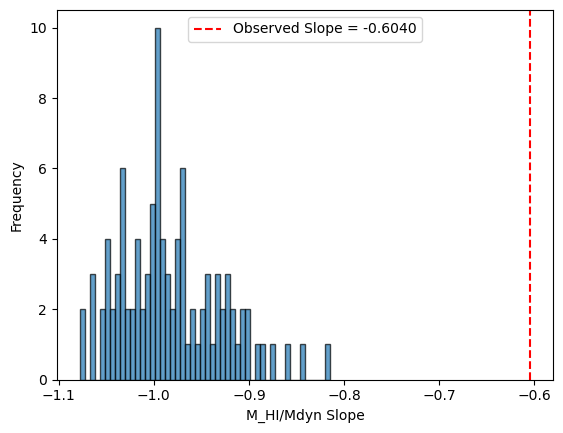

In [45]:
MhMdVMdSlope, MhMdVMdIntercept = plotWithFit(
    np.log10(Mdyn[mask].values), 
    np.log10((M_h1[mask] / Mdyn[mask]).values),
    r'$M_{dyn}$ [M$_\odot$]', r'$M_{H I}/M_{dyn}$ [M$_\odot/M_\odot$]'
)

sanityCheck(Mdyn[mask].values, M_h1[mask].values, 100, MhMdVMdSlope, 'M_HI/Mdyn Slope')

-0.8308299122036187
-0.19592400033277457


/tmp/ipykernel_355771/3053669086.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = res.params[1], res.params[0]


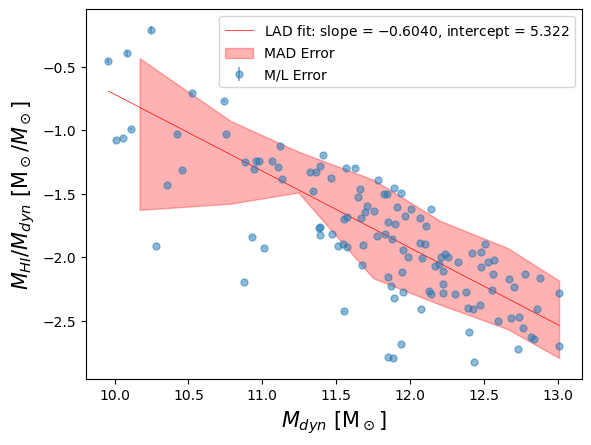

(-0.6039880697265396, 5.322240257774248)

In [46]:
plotWithFitErr(np.log10(Mdyn[mask]), np.log10(M_h1[mask]/Mdyn[mask]), 
               (M_h1[mask]/Mdyn[mask] * percent_error), .5,
               r'$M_{dyn}$ [M$_\odot$]', r'$M_{H I}/M_{dyn}$ [M$_\odot/M_\odot$]')

/tmp/ipykernel_355771/3053669086.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = res.params[1]
/tmp/ipykernel_355771/3053669086.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = res.params[0]
/tmp/ipykernel_355771/3053669086.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label=f'LAD fit: slope = {res.params[1]:.4f}, intercept = {res.params[0]:.3f}')


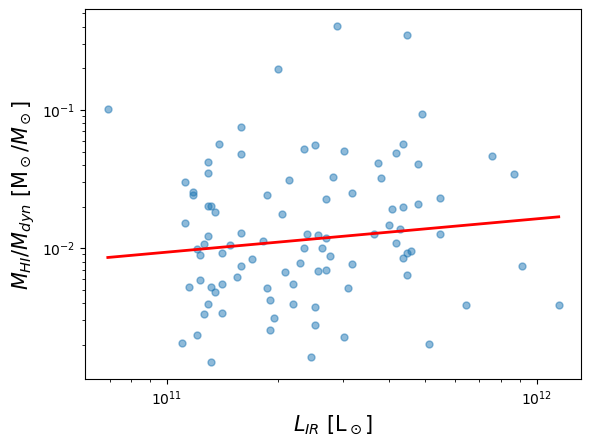

In [47]:
NGEMMask = df1.fit.astype(str).str.contains('1', na=False) & (df1.w20 >= 0.0)

niceSlope, niceIntercept = plotWithFit(
    logLir[NGEMMask], 
    np.log10(M_h1[NGEMMask] / Mdyn[NGEMMask]),
    r'$L_{IR}$ [L$_\odot$]', r'$M_{H I}/M_{dyn}$ [M$_\odot/M_\odot$]')

94 points for EM-NG
26 points for EM-G
6 points for EM+ABS
Total number of points plotted: 126


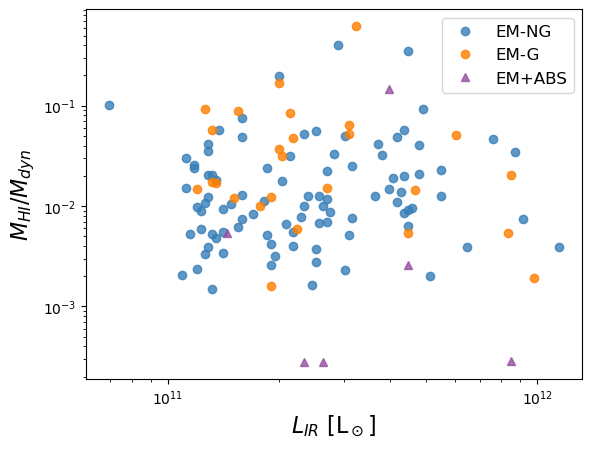

In [48]:
def MhMdVLPlot(df1):

    count = 0
    exclude_codes = ['0', '3', '4']
    mask = ~df1.fit.astype(str).str.contains('|'.join(exclude_codes), na=False) & (df1.w20 >= 0.0)

    newDF = df1[mask].reset_index(drop=True)
    Lir = np.power(10, newDF['log(Lir)'])
    dist = newDF['Dlum[Mpc]']  # Use 'Dlum[Mpc]' for distance in Mpc
    SHI = newDF['line[Jykm/s]']

    c = 299792.458  # km/s
    velocity = newDF['50centerVel']
    z = velocity / c  # Convert velocity to redshift

    M_h1 = (2.36e5/(1+z)**2) * SHI * dist**2
    deltaV20 = newDF.w20
    Mdyn = 40 * deltaV20**4

    filtered_code_info = [
    ('1', '#377eb8', 'EM-NG', 'o'),
    ('2', '#ff7f00', 'EM-G', 'o'),
    ('5', '#984ea3', 'EM+ABS', '^'),
    ]    

    for code_val, color, label, marker in filtered_code_info:
        idx = newDF.fit.astype(str).str.contains(code_val, na=False)
        n_points = idx.sum()
        count += n_points
        if n_points > 0:
            plt.loglog(Lir[idx], (M_h1 / Mdyn)[idx], marker, markersize=6, color=color, alpha=0.8, label=label)
            print(f"{n_points} points for {label}")

    plt.xlabel(r'$L_{IR}$ [L$_\odot$]', fontsize=16)
    plt.ylabel(r'$M_{H I}/M_{dyn}$', fontsize=16)
    plt.legend(fontsize=12)
    print(f"Total number of points plotted: {count}")
    plt.savefig('MhMdVLPlot.png')
    plt.show()

MhMdVLPlot(df1)



Galaxy: F13126+2453
Difference: 552.1999999999998 km/s
Optical Velocity: 3346.0 km/s
Radio Velocity: 3898.2 km/s

Galaxy: F11011+4107
Difference: 384.0 km/s
Optical Velocity: 10349.0 km/s
Radio Velocity: 10733.0 km/s

Galaxy: F23444+2911
Difference: 313.6999999999998 km/s
Optical Velocity: 4845.0 km/s
Radio Velocity: 5158.7 km/s

Most Negative Difference:
Galaxy: F12112+0305
Difference: -175.79999999999927 km/s
Optical Velocity: 21978.0 km/s
Radio Velocity: 21802.2 km/s


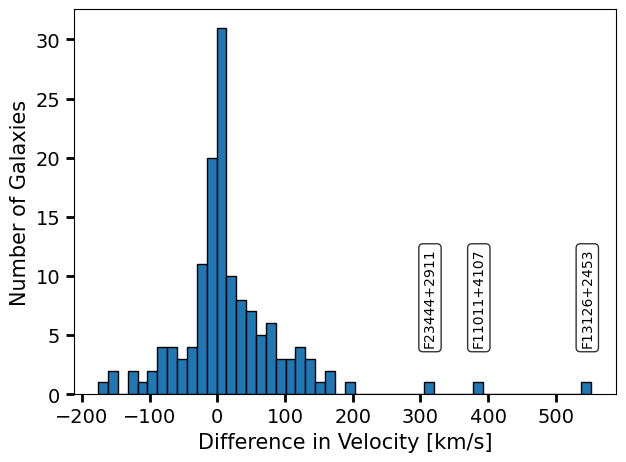

In [49]:
df2 = pd.read_csv(folder_path + 'TABmeas_v2.csv', skiprows=None)

# Filter out rows in df1 where cz == 0
mask = df1['50centerVel'] != 0
filtered_df1 = df1[mask].reset_index(drop=True)

# Get the names of the remaining galaxies
remaining_names = set(filtered_df1['name'])

# Filter df2 to keep only rows with names in remaining_names
filtered_df2 = df2[df2['name'].isin(remaining_names)].reset_index(drop=True)


czVel = np.array(filtered_df1['OptVel[km/s]'])
radVel = np.array(filtered_df1['50centerVel'])

differenceVel = radVel - czVel

# Plot histogram of velocity differences
fig2, ax2 = plt.subplots(figsize=(7, 5))
ax2.hist(differenceVel, bins=50, edgecolor='black')
ax2.set_xlabel('Difference in Velocity [km/s]', fontsize=15)
ax2.set_ylabel('Number of Galaxies', fontsize=15)
ax2.tick_params(axis='both', which='both', length=6, width=2, labelsize=14)
ax2.text(0.96, 0.38, 'F13126+2453', transform=ax2.transAxes, rotation=90, 
         verticalalignment='top', horizontalalignment='right', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.text(0.76, 0.38, 'F11011+4107', transform=ax2.transAxes, rotation=90, 
         verticalalignment='top', horizontalalignment='right', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.text(0.67, 0.38, 'F23444+2911', transform=ax2.transAxes, rotation=90, 
         verticalalignment='top', horizontalalignment='right', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
# ax2.text(0.05, 0.38, 'F12112+0305', transform=ax2.transAxes, rotation=90, 
#          verticalalignment='top', horizontalalignment='right', fontsize=10,
#          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
fig2.savefig('velocity_difference_histogram.png')
         
names = filtered_df1['name'].values

# Find and print top 3 largest positive velocity differences
for _ in range(3):
    idx = np.argmax(differenceVel)
    print(f'Galaxy: {names[idx]}')
    print(f'Difference: {differenceVel[idx]} km/s')
    print(f'Optical Velocity: {czVel[idx]} km/s')
    print(f'Radio Velocity: {radVel[idx]} km/s\n')
    
    # Remove this entry from all arrays
    differenceVel = np.delete(differenceVel, idx)
    czVel = np.delete(czVel, idx)
    radVel = np.delete(radVel, idx)
    names = np.delete(names, idx)

# Smallest (most negative) difference
idx = np.argmin(differenceVel)
print('Most Negative Difference:')
print(f'Galaxy: {names[idx]}')
print(f'Difference: {differenceVel[idx]} km/s')
print(f'Optical Velocity: {czVel[idx]} km/s')
print(f'Radio Velocity: {radVel[idx]} km/s')

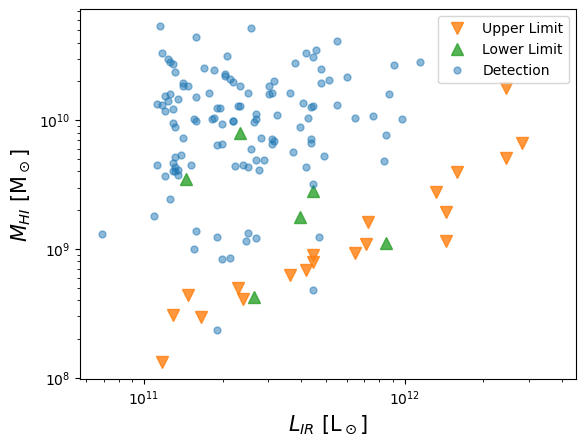

In [50]:
plt.ylabel(r'$M_{H I}$ [M$_\odot$]', fontsize=15)
plt.xlabel(r'$L_{IR}$ [L$_\odot$]', fontsize=15)



# Plot triangles for special codes
# Debug: Print how many entries match each code
for code_val, marker, color, label in [('NoDet', 'v', 'C1', "Upper Limit"), ('EM_ABS', '^', 'C2', "Lower Limit")]:
    idx = df2.ProfileCode.astype(str).str.contains(code_val, na=False)
    if idx.any():
        plt.loglog(Lir[idx], np.power(10, df2['Log(M_HI)'][idx]), marker, markersize=8, color=color, alpha=0.8, label=label)

# Plot circles for all other points
other_idx = ~df2.ProfileCode.astype(str).str.contains('NoDet|EM_ABS', na=False)
if other_idx.any():
    plt.loglog(Lir[other_idx], M_h1[other_idx], 'o', markersize=5, alpha=0.5, label="Detection")

plt.legend()
plt.savefig('entire_sample_plot.png')
plt.show()

In [51]:
df3

,IRAS Name,Common Name,12CO line (Jykm/s),line error,Log(MH2) (Larson),Merger State,source
0,F00085-1223,NGC 0034,126.0,3.6,NaN,M4,both
1,F00163-1039,MCG-02-01-051,60.9,2.9,NaN,M2,both
2,F00402-2349,NGC 0232,NaN,NaN,10.18,TM2,Larson
3,F01053-1746,IC 1623,469.2,1.9,10.51,M3,both
4,F01076-1707,MCG-03-04-014,96.0,1.2,10.34,amb,both
...,...,...,...,...,...,...,...
78,F23024+1916,CGCG 453-062,60.4,3.0,NaN,s,both
79,F23135+2517,IC 5298,NaN,NaN,9.95,m,Larson
80,F23157-0441,NGC 7592,NaN,NaN,10.34,M3,Larson
81,F23254+0830,NGC 7674,NaN,NaN,10.12,M2,Larson


In [52]:
MH2_list = []
for idx, row1 in df1.iterrows():
    iras_name = row1['name']
    match3 = df3[df3['IRAS Name'] == iras_name]
    if not match3.empty:
        co_line = match3['12CO line (Jykm/s)'].values[0]
        if pd.notna(co_line) and str(co_line).lower() != 'nan':
            Dlum = row1['Dlum[Mpc]']
            vel = row1['50centerVel']
            MH2 = 2 * 3.25e7 * float(co_line) * Dlum**2 * (1 / (1 + (vel / c))) * (1/115.2712)**2
            MH2_list.append((iras_name, MH2))
        else:
            log_mh2 = match3['Log(MH2) (Larson)'].values[0]
            if pd.notna(log_mh2) and str(log_mh2).lower() != 'nan':
                MH2_list.append((iras_name, 10**float(log_mh2)/3.225))
            else:
                MH2_list.append((iras_name, np.nan))
    else:
        MH2_list.append((iras_name, np.nan))



In [53]:
df2 = df2.merge(df3[['IRAS Name', 'Merger State']], how='left', left_on='name', right_on='IRAS Name')
if 'IRAS Name' in df2.columns:
	df2 = df2.drop(columns=['IRAS Name'])
if 'Merger State' not in df2.columns:
	df2['Merger State'] = np.nan
df2

,name,int_time,S_HISign,S_HI,S_HIErr,HI_Vel,HI_VelErr,W50,W50Err,W20,...,CFD,CFDErr,CPSSign,CPS,CRMS,MassSign,Log(M_HI),LogM_HIErr,ProfileCode,Merger State
0,F00073+2538,65.2,NaN,9.04,0.91,4567.0,6.0,381.4,11.5,453.1,...,0.195,0.065,NaN,29.18,1.95,NaN,9.94,0.04,EM_NG,NaN
1,F00085-1223,84.1,NaN,4.48,0.46,5881.0,20.0,292.6,54.2,432.4,...,0.195,0.065,NaN,21.01,2.08,NaN,9.86,0.04,EM_NG,M4
2,F00163-1039,117.5,NaN,5.95,0.60,8143.0,5.0,257.6,8.8,309.5,...,0.951,0.115,NaN,32.08,1.96,NaN,10.26,0.04,EM_NG,M2
3,F00344-3349,89.0,NaN,0.13,0.06,6238.0,25.0,90.6,12.6,147.9,...,0.195,0.065,NaN,8.69,1.63,NaN,8.37,0.18,EM_G,NaN
4,F00402-2349,95.2,NaN,2.01,0.21,6762.0,19.0,255.3,20.5,329.6,...,0.195,0.065,NaN,11.29,1.68,NaN,9.61,0.05,EM_NG,TM2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,F23394-0353,100.0,NaN,10.95,1.10,6932.0,12.0,248.7,23.2,400.0,...,0.195,0.065,NaN,52.12,1.90,NaN,10.39,0.04,EM_NG,NaN
157,23436+5257,149.0,NaN,1.15,0.12,10248.0,18.0,156.4,29.8,241.6,...,0.195,0.065,NaN,9.70,1.07,NaN,9.75,0.05,EM_NG,NaN
158,F23444+2911,73.6,NaN,26.90,2.69,5144.0,5.0,372.5,5.0,431.1,...,0.195,0.065,NaN,89.20,2.93,NaN,10.52,0.04,EM_NG,NaN
159,F23488+1949,61.2,NaN,18.82,1.89,4299.0,10.0,466.0,19.7,617.4,...,0.195,0.065,NaN,49.27,2.23,NaN,10.21,0.04,EM_NG,M2


In [54]:
print(MH2_list)

[('F00073+2538', nan), ('F00085-1223', 4275221240.7541447), ('F00163-1039', 4004315569.50769), ('F00344-3349', nan), ('F00402-2349', 4693213173.445603), ('F00506+7248', nan), ('F00548+4331', nan), ('F01053-1746', 16439933051.734055), ('F01076-1707', 9737959080.751753), ('F01173+1405', nan), ('F01364-1042', 8068297802.456625), ('F01417+1651', nan), ('F01484+2220', 8540244041.358645), ('F01519+3640', nan), ('F02070+3857', nan), ('F02071-1023', nan), ('F02114+0456', 4959076856.064835), ('F02152+1418', nan), ('F02203+3158', nan), ('F02208+4744', 4498066065.55897), ('F02281-0309', 4493306193.340771), ('F02345+2053', nan), ('F02401-0013', 2246313054.4960904), ('F02435+1253', 5028868518.942428), ('F02437+2122', nan), ('F02512+1446', nan), ('F03117+4151', nan), ('F03217+4022', nan), ('F03359+1523', 8345844353.261748), ('F03514+1546', nan), ('03582+6012', nan), ('F04097+0525', nan), ('F04118-3207', nan), ('F04191-1855', 6387600006.919188), ('04271+3849', nan), ('F04315-0840', 3814786886.2399416

In [55]:
df2['MH2'] = [x[1] for x in MH2_list]

In [56]:
# Merge log(Lir) and Lir into df2 based on 'name'
df2 = df2.merge(df1[['name', 'log(Lir)']], on='name', how='left')
df2['Lir'] = 10 ** df2['log(Lir)']

In [57]:
df2 = df2.merge(df4[['SOURCE', 'Mstar(MS)', 'SFR']], how='left', left_on='name', right_on='SOURCE')
df2['Mstar(MS)'] = df2['Mstar(MS)'].fillna(np.nan)
df2['SFR'] = df2['SFR'].fillna(np.nan)
df2 = df2.drop(columns=['SOURCE'])

0.1058181878606582 8.73351404474501


/tmp/ipykernel_355771/3863792605.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = res.params[1], res.params[0]


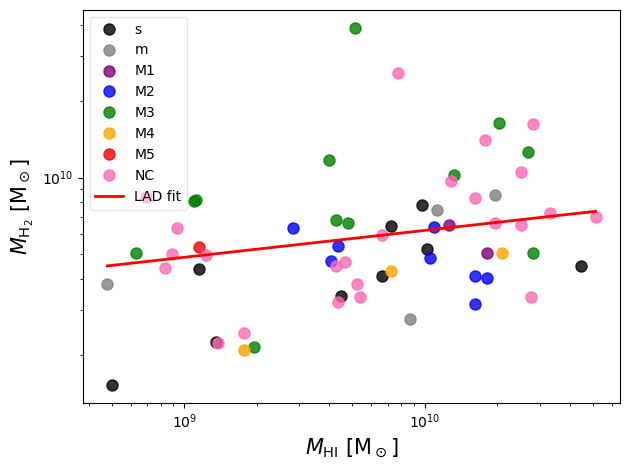

In [58]:
mask = pd.to_numeric(df2['Log(M_HI)'], errors='coerce') > 1

for type, color, label in [
    ('s', 'k', 's'),
    ('m', 'grey', 'm'),
    ('M1', 'purple', 'M1'),
    ('M2', 'blue', 'M2'),
    ('M3', 'green', 'M3'),
    ('M4', 'orange', 'M4'),
    ('M5', 'red', 'M5'), 
]:
    idx = df2['Merger State'].astype(str).str.contains(f'^{type}$|^T{type}$', na=False)
    combined = idx & mask
    if combined.any():
        plt.loglog(
            10**df2.loc[combined, 'Log(M_HI)'],
            df2.loc[combined, 'MH2'],
            'o', markersize=8, color=color, alpha=0.8, label=label
        )

nan_idx = df2['Merger State'].isna() & mask
if nan_idx.any():
    plt.loglog(
        10**df2.loc[nan_idx, 'Log(M_HI)'],
        df2.loc[nan_idx, 'MH2'],
        'o', markersize=8, color='hotpink', alpha=0.8, label='NC'
    )

fix = ~pd.isna(df2['MH2'])
combined_mask = mask & fix
X = (10**df2['Log(M_HI)'][combined_mask]).reset_index(drop=True)
y = (df2['MH2'][combined_mask]).reset_index(drop=True)

X_ = sm.add_constant(np.log10(X))
mod = sm.QuantReg(np.log10(y), X_)
res = mod.fit(q=0.5)

X_pred = np.linspace(np.log10(X.min()), np.log10(X.max()), 100)
X_pred_ = sm.add_constant(X_pred)
y_pred = res.predict(X_pred_)
slope, intercept = res.params[1], res.params[0]

print(slope,intercept)

plt.loglog(10**X_pred, 10**y_pred, color='red', linewidth=2, label='LAD fit')
plt.xlabel(r'$M_{\mathrm{HI}}$ [M$_\odot$]', fontsize=15)
plt.ylabel(r'$M_{\mathrm{H_2}}$ [M$_\odot$]', fontsize=15)
plt.legend(loc='upper left', framealpha=0.5)
plt.tight_layout()
plt.show()


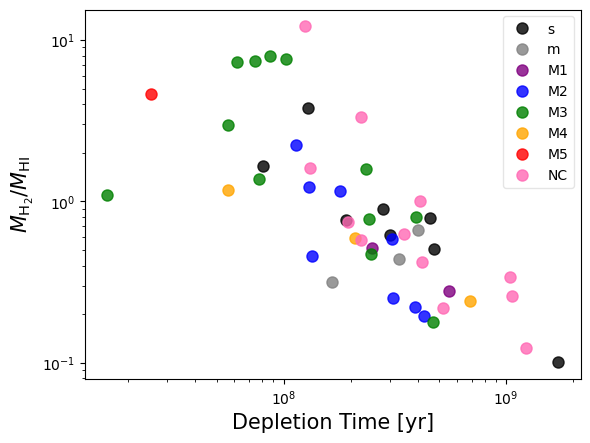

In [83]:
mask = pd.to_numeric(df2['Log(M_HI)'], errors='coerce') > 1

for type, color, label in [
    ('s', 'k', 's'),
    ('m', 'grey', 'm'),
    ('M1', 'purple', 'M1'),
    ('M2', 'blue', 'M2'),
    ('M3', 'green', 'M3'),
    ('M4', 'orange', 'M4'),
    ('M5', 'red', 'M5'), 
]:
    idx = df2['Merger State'].astype(str).str.contains(f'^{type}$|^T{type}$', na=False)
    combined = idx & mask
    if combined.any():
        plt.loglog(
            (10**df2.loc[combined, 'Log(M_HI)'] + df2.loc[combined, 'MH2'])/df2.loc[combined, 'SFR'],
            df2.loc[combined, 'MH2']/10**df2.loc[combined, 'Log(M_HI)'],
            'o', markersize=8, color=color, alpha=0.8, label=label
        )

nan_idx = df2['Merger State'].isna() & mask
if nan_idx.any():
    plt.loglog(
        (10**df2.loc[nan_idx, 'Log(M_HI)'] + df2.loc[nan_idx, 'MH2'])/df2.loc[nan_idx, 'SFR'],
        df2.loc[nan_idx, 'MH2']/10**df2.loc[nan_idx, 'Log(M_HI)'],
        'o', markersize=8, color='hotpink', alpha=0.8, label='NC'
    )


plt.xlabel('Depletion Time [yr]', fontsize=15)
plt.ylabel(r'$M_{\mathrm{H_2}}/M_{\mathrm{HI}}$', fontsize=15)
plt.legend(loc='upper right', framealpha=0.5)

0.1058181878606582 8.73351404474501
-0.020838145063620202
0.18461524685833053


/tmp/ipykernel_355771/3053669086.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = res.params[1], res.params[0]


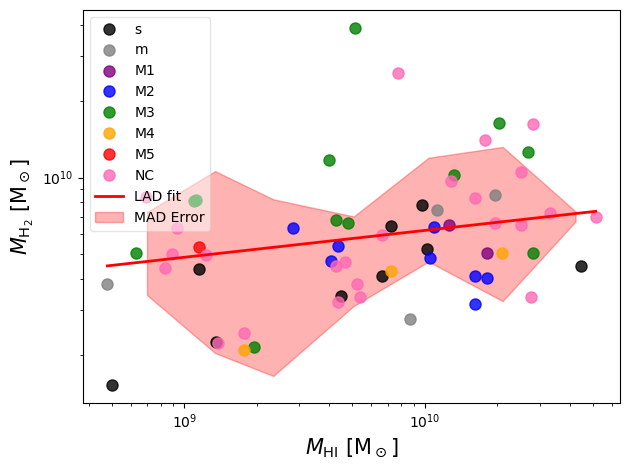

In [60]:
mask = pd.to_numeric(df2['Log(M_HI)'], errors='coerce') > 1

for type, color, label in [
    ('s', 'k', 's'),
    ('m', 'grey', 'm'),
    ('M1', 'purple', 'M1'),
    ('M2', 'blue', 'M2'),
    ('M3', 'green', 'M3'),
    ('M4', 'orange', 'M4'),
    ('M5', 'red', 'M5'), 
]:
    idx = df2['Merger State'].astype(str).str.contains(f'^{type}$|^T{type}$', na=False)
    combined = idx & mask
    if combined.any():
        plt.loglog(
            10**df2.loc[combined, 'Log(M_HI)'],
            df2.loc[combined, 'MH2'],
            'o', markersize=8, color=color, alpha=0.8, label=label
        )

nan_idx = df2['Merger State'].isna() & mask
if nan_idx.any():
    plt.loglog(
        10**df2.loc[nan_idx, 'Log(M_HI)'],
        df2.loc[nan_idx, 'MH2'],
        'o', markersize=8, color='hotpink', alpha=0.8, label='NC'
    )

fix = ~pd.isna(df2['MH2'])
combined_mask = mask & fix
X = df2['Log(M_HI)'][combined_mask].reset_index(drop=True)
y = np.log10(df2['MH2'][combined_mask].reset_index(drop=True))

plotWithFitMAD(X, y, 0.3)

# X_ = sm.add_constant(np.log10(X))
# mod = sm.QuantReg(np.log10(y), X_)
# res = mod.fit(q=0.5)

# X_pred = np.linspace(np.log10(X.min()), np.log10(X.max()), 100)
# X_pred_ = sm.add_constant(X_pred)
# y_pred = res.predict(X_pred_)
# slope, intercept = res.params[1], res.params[0]

# print(slope,intercept)

#plt.loglog(10**X_pred, 10**y_pred, color='red', linewidth=2, label='LAD fit')
plt.xlabel(r'$M_{\mathrm{HI}}$ [M$_\odot$]', fontsize=15)
plt.ylabel(r'$M_{\mathrm{H_2}}$ [M$_\odot$]', fontsize=15)
plt.legend(loc='upper left', framealpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_355771/3053669086.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope, intercept = res.params[1], res.params[0]


0.4385310182776928 -5.085819456766203
-0.4829209403475156
1.4696148545312184


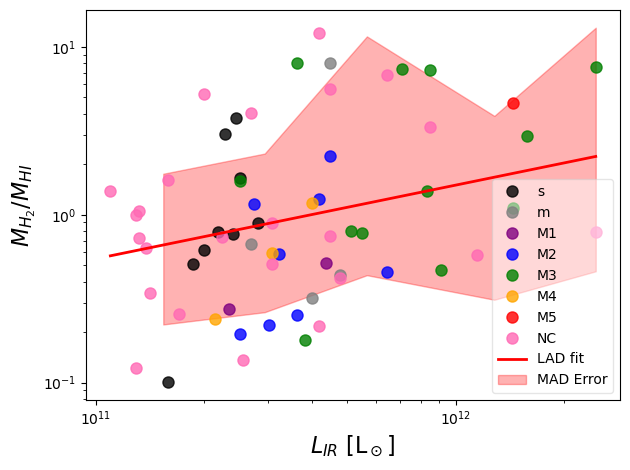

In [69]:
mask = pd.to_numeric(df2['Log(M_HI)'], errors='coerce') > 1
for type, color, label in [
    ('s', 'k', 's'),
    ('m', 'grey', 'm'),
    ('M1', 'purple', 'M1'),
    ('M2', 'blue', 'M2'),
    ('M3', 'green', 'M3'),
    ('M4', 'orange', 'M4'),
    ('M5', 'red', 'M5')
]:
    idx = df2['Merger State'].astype(str).str.contains(f'^{type}$|^T{type}$', na=False)
    combined = idx & mask
    if combined.any():
        plt.loglog(df2['Lir'][combined], df2['MH2'][combined] / (10**df2['Log(M_HI)'][combined]), 
                   'o', markersize=8, color=color, alpha=0.8, label=label)

# Handle NaN types
nan_idx = df2['Merger State'].isna() & mask
if nan_idx.any():
    plt.loglog(df2['Lir'][nan_idx], df2['MH2'][nan_idx] / (10**df2['Log(M_HI)'][nan_idx]), 
               'o', markersize=8, color='hotpink', alpha=0.8, label='NC')

fix = ~pd.isna(df2['MH2'])

combined_mask = mask & fix
X = (np.log10(df2['Lir'][combined_mask])).reset_index(drop=True)
y = (np.log10(df2['MH2'][combined_mask]/(10**df2['Log(M_HI)'][combined_mask]))).reset_index(drop=True)

plotWithFitMAD(X, y, 0.3)

plt.xlabel(r'$L_{IR}$ [L$_\odot$]', fontsize=16)
plt.ylabel(r'$M_{H_2}/M_{HI}$', fontsize=16)
plt.legend(loc='lower right', framealpha=0.5)
plt.tight_layout()
plt.show()


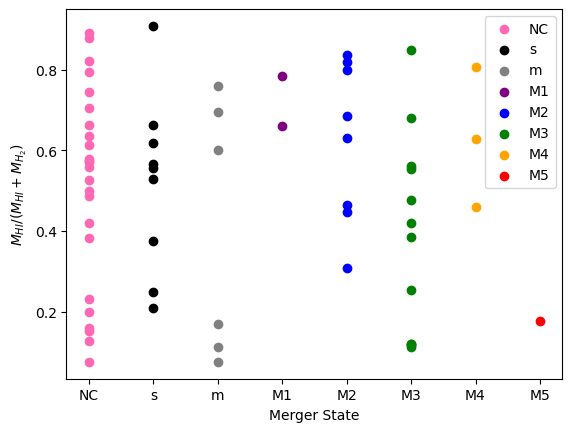

In [62]:
my_xticks = ['NC','s', 'm', 'M1', 'M2', 'M3', 'M4', 'M5']
x = [1, 3, 5, 7, 9, 11, 13, 15]

fraction = 10**df2['Log(M_HI)']/ (10**df2['Log(M_HI)'] + df2['MH2'])

mask = pd.to_numeric(df2['Log(M_HI)'], errors='coerce') > 1

nan_idx = df2['Merger State'].isna() & mask
if nan_idx.any():
    plt.scatter([1]*nan_idx.sum(), fraction[nan_idx], color='hotpink', label='NC')

    
for type, color, label, assignment in [
    ('s', 'k', 's', 3), 
    ('m','grey', 'm', 5), 
    ('M1','purple', 'M1', 7), 
    ('M2','blue', 'M2', 9), 
    ('M3','green', 'M3', 11), 
    ('M4','orange', 'M4', 13), 
    ('M5','red', 'M5', 15)
]:
    idx = df2['Merger State'].astype(str).str.contains(type, na=False)
    combined = idx & mask
    if combined.any():
        plt.scatter([assignment]*combined.sum(), fraction[combined], color=color, label=label)
        


plt.xticks(x, my_xticks)
plt.xlabel('Merger State')
plt.ylabel(r'$M_{HI}/ (M_{HI} + M_{H_2})$')
plt.legend()
plt.show()